In [1]:
%load_ext autoreload
%autoreload 2
import healpy as hp
from spectral_index import find_spec_index
import numpy as np
import matplotlib.pyplot as pl
import h5py
import fgivenx
from scipy import stats
from astropy import units as u
import astropy
import copy
import os
from fgivenx import plot_contours, plot_lines, plot_dkl
from reconstruct_map import Reconstructor

#extrapolate
def extrapolate_in_nu(map_in, nu_base, nu_desired, beta):
    map_in_copy = map_in.copy()
    return map_in_copy*(nu_desired/nu_base)**(-beta)

def apply_hp_mask(map_in, threshold):
    map_out = map_in.copy()
    for i in range(map_in.shape[0]):
        if map_in[i] == threshold:
            map_out[i] = hp.UNSEEN
    return map_out

#they both do the same thing
def apply_hp_mask(map_in, threshold):
    mask = np.where(map_in == threshold)
    map_out = map_in.copy()
    for i in range(len(mask[0])):
        map_out[mask[0][i]] = hp.UNSEEN
        
    return map_out


def replace_area_with_number(map_to_be_replaced, value, map_replacer):
#takes in a map, finds the masked regions and replaces it with the value found in another map
    map_to_be_replaced_copy = map_to_be_replaced.copy()
    map_replacer_copy = map_replacer.copy()
    regions_to_replace = np.where(map_to_be_replaced_copy == value)
    for i in range(len(regions_to_replace[0])):
        map_to_be_replaced_copy[regions_to_replace[0][i]] = map_replacer_copy[regions_to_replace[0][i]]

    return map_to_be_replaced_copy


def copy_masked_area_from_one_to_another(map_with_masks, map_to_be_masked):
#takes in a map, finds the masked regions and replaces it with the value found in another map
    map_with_masks_copy = map_with_masks.copy()
    map_to_be_masked_copy = map_to_be_masked.copy()
    regions_to_replace = np.where(map_with_masks_copy == hp.UNSEEN)
    for i in range(len(regions_to_replace[0])):
        map_to_be_masked_copy[regions_to_replace[0][i]] = hp.UNSEEN

    return map_to_be_masked_copy


def mean_unmasked_region(map_with_masks, mask_value):
    masked_regions = np.where(map_with_masks == mask_value)
    #make a copy
    map_with_masks_copy = map_with_masks.copy()
    try:
        n = 0
        for i in range(len(masked_regions[0])):
            map_with_masks_copy[masked_regions[0][i]] = 0
            n += 1
        return np.sum(map_with_masks_copy)/float(len(map_with_masks_copy ) - n)
    except:
        print('There are no masked regions')
        return np.mean(map_with_masks_copy)
            
            

def convert_ell_to_degrees(ell):
    return float(360)/float(2*ell)

def convert_ell_to_rads(ell):
    return float(2*np.pi)/float(2*ell)


In [2]:
#load the usual suspects

path2maps = '/Users/michael/Research/REACH/amp_scale_factor/chains/Offset_Tests/May/Guzman_map/'

guzman = np.load(os.path.join(path2maps, 'guzman_45.npy'))
base_230 = np.load(os.path.join(path2maps, 'base_map_230.npy'))
guzman_real = np.load(os.path.join(path2maps, 'Guzman_45MHz_base_map.npy'))

#below is only useful for the initial conversion from FITS to ring map
allsky_150MHz = np.load('/Users/michael/Downloads/AllSky_150MHz.npy')


allsky_150MHz = np.load('allsky_150MHz.npy')
#hp.visufunc.mollview(allsky_150MHz , title = "All Sky 150MHz")

#means
mean_base_230 = np.mean(base_230)
mean_allsky_150MHz = np.mean(allsky_150MHz)

print(mean_allsky_150MHz)


399.7996


## Make a fictional noise map

/Users/michael/miniconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/michael/miniconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/michael/miniconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able 

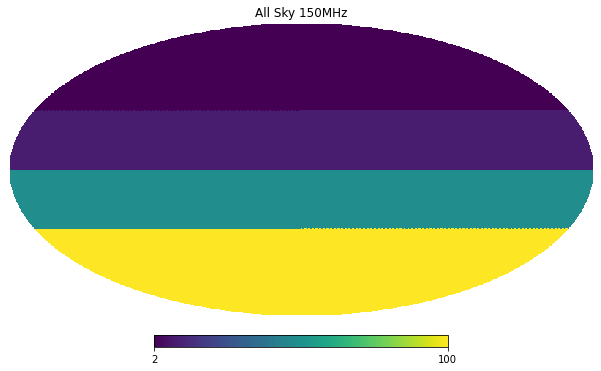

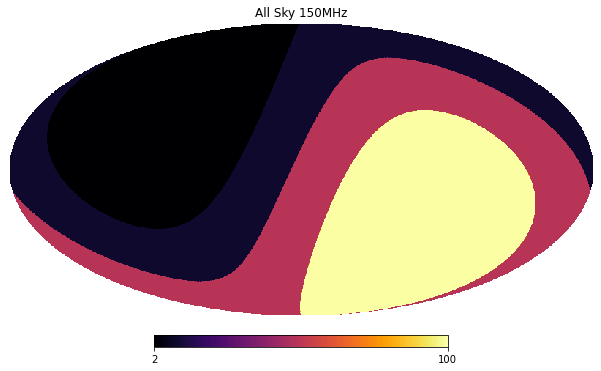

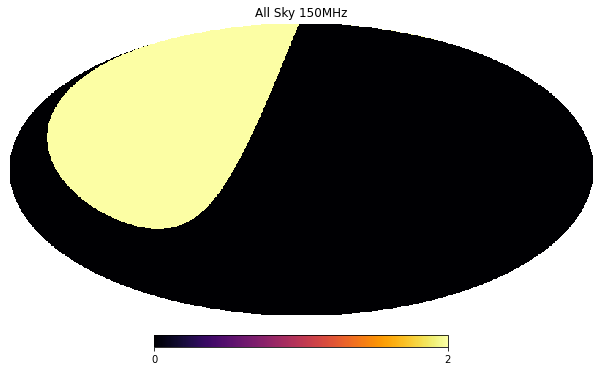

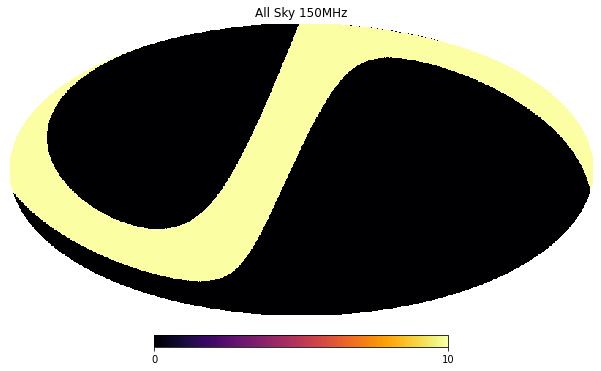

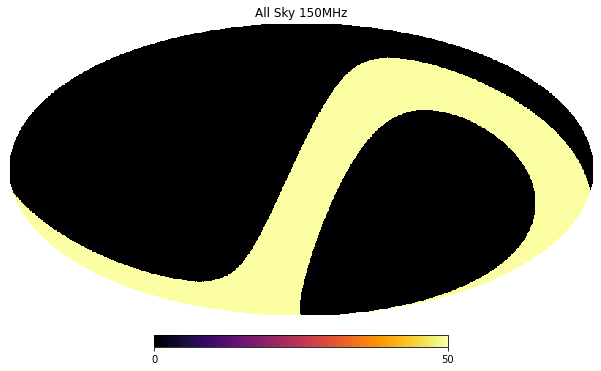

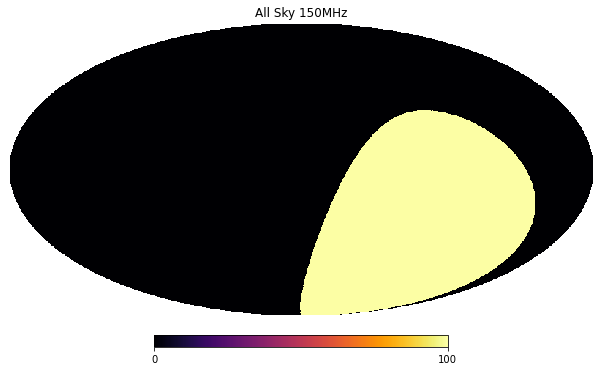

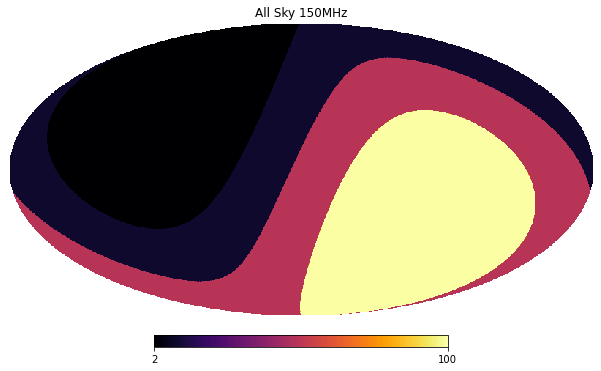

In [3]:
from healpy import rotator
noise = np.zeros_like((base_230))

delta_pix = int(len(base_230)/4.)

error_values = (2,10, 50, 100)

for i in range(4):
    noise[i*delta_pix: (i+1)*delta_pix] = error_values[i]
    
r = rotator.Rotator(coord=['E','G'])

noise_gal = r.rotate_map_pixel(noise)
hp.visufunc.mollview(noise ,   title = "All Sky 150MHz")

hp.visufunc.mollview(noise_gal ,   title = "All Sky 150MHz", cmap = 'inferno')

#let us degenerately smooth this map
for i in range(len(error_values)):
    indicies = np.where( np.abs(noise_gal - error_values[i]) <= 0.1 )[0]
    noise_gal[indicies] = error_values[i]
    #check
    hp.visufunc.mollview(np.where( noise_gal == error_values[i] , noise_gal,0 ) ,  title = "All Sky 150MHz", cmap = 'inferno')
                          
hp.visufunc.mollview(noise_gal ,  title = "All Sky 150MHz", cmap = 'inferno')



## Add to all sky map

0.15270253951688342


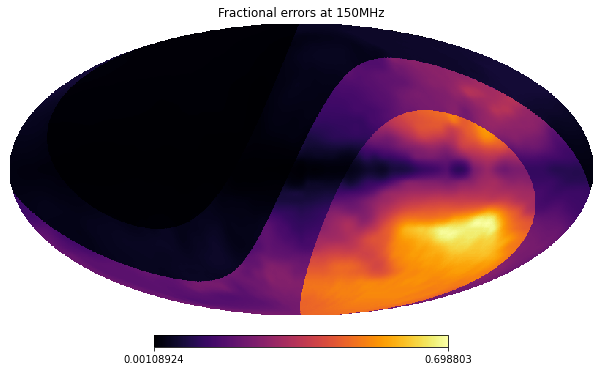

In [4]:
Fractional_errors150MHz = np.true_divide(noise_gal, allsky_150MHz)

hp.visufunc.mollview(Fractional_errors150MHz , cmap = 'inferno',  title = 'Fractional errors at 150MHz')

print(np.mean(Fractional_errors150MHz))




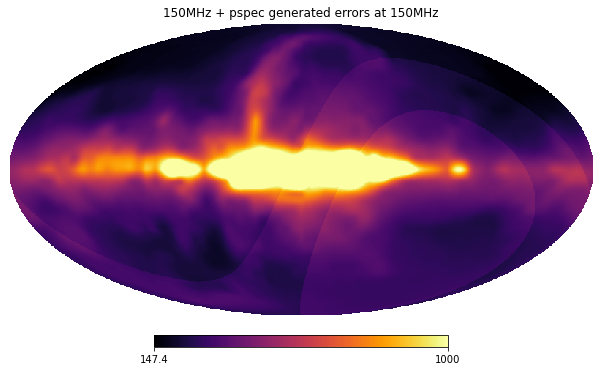

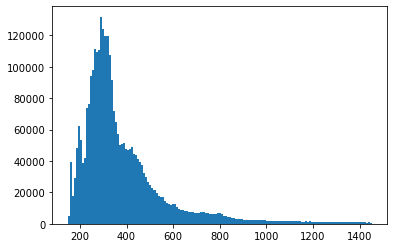

Mean of the noisy map is 440.29939311457673 compared to the original 399.7996


In [5]:
#150Mhz  + noise
allsky_150MHz_wNoise = allsky_150MHz + noise_gal

hp.visufunc.mollview(allsky_150MHz_wNoise , cmap = 'inferno', max = 1000, title = '150MHz + pspec generated errors at 150MHz')
pl.show()
pl.close()
pl.hist(allsky_150MHz_wNoise, bins = np.linspace(np.min(allsky_150MHz_wNoise),np.max(allsky_150MHz_wNoise)/5., 150))
pl.show()
pl.close()

print('Mean of the noisy map is ' + str(np.mean(allsky_150MHz_wNoise)) + ' compared to the original ' + str(mean_allsky_150MHz) )

#save noise and original
#np.save('allsky_150MHz_wArtificialErrors_4Reg.npy', allsky_150MHz_wNoise)
#np.save('allsky_150MHz.npy', allsky_150MHz)
#np.save('ArtificialErrors_4reg.npy', noise_gal)


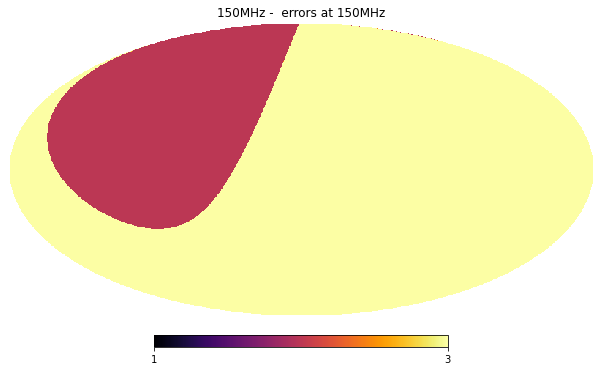

In [6]:
#check to make sure everything went well
hp.visufunc.mollview(allsky_150MHz_wNoise - allsky_150MHz , min = 1, max = 3, cmap = 'inferno',title = '150MHz -  errors at 150MHz')


## Compute the power spectrum from the errormap


Multipole 1 or in degrees 180.0


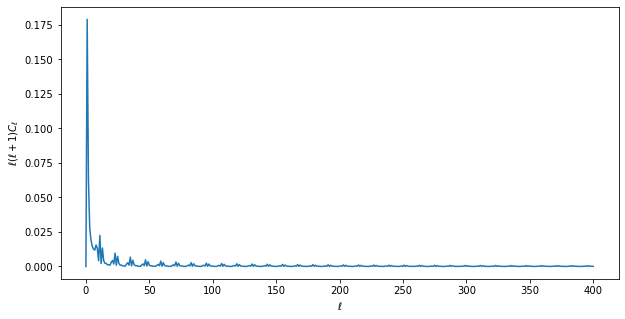

In [7]:
#compute the angular power spectrum of the contrast map

#hp.visufunc.mollview(errors150MHz_nside512, cmap = 'RdBu')

cl = hp.sphtfunc.anafast(Fractional_errors150MHz , lmax = 400)
ell = np.arange(len(cl))

pl.figure(figsize=(10, 5))
pl.plot(ell, ell * (ell + 1) * cl)
pl.xlabel("$\ell$")
pl.ylabel("$\ell(\ell+1)C_{\ell}$")


#next convert multipole moment l to physical length
#first nomarlize the cl 
cl_norm = np.multiply(ell * (ell + 1), cl)

correlation_length = convert_ell_to_degrees(ell[np.argmax(cl_norm)])
print('Multipole ' + str(ell[np.argmax(cl_norm)]) + ' or in degrees ' + str(correlation_length))





## Generate Masks

the temperature dividers are  5  long 
The max of the map is  100.0
dividing percentiles are  1.0
dividing percentiles are  49.0
dividing percentiles are  97.0
the temperature dividers are  [  2.   2.  10. 100. 100.]
values must be between  2.0  percentile and  2.0
values must be between  2.0  percentile and  10.0
values must be between  10.0  percentile and  100.0


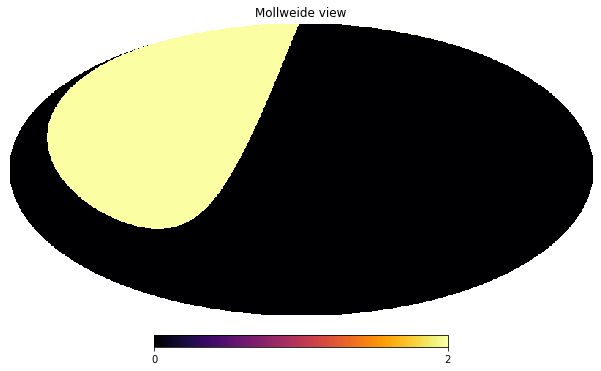

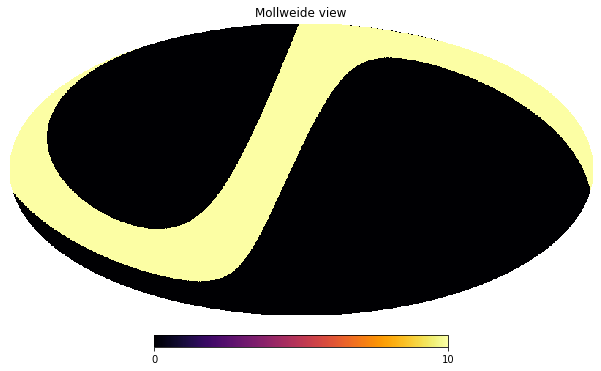

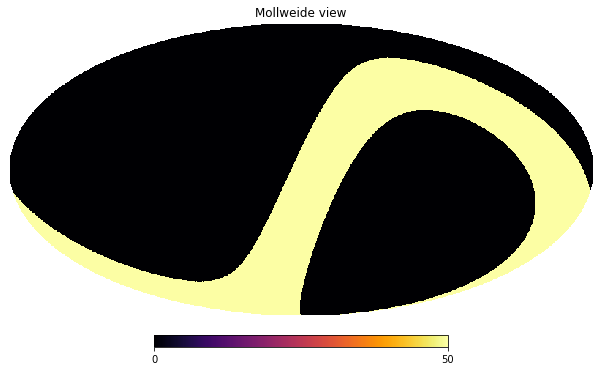

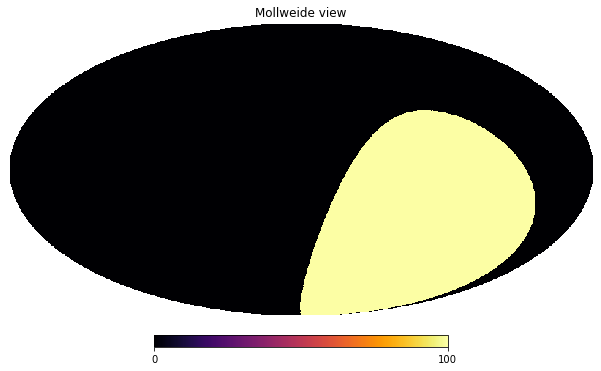

----------------------------------------------------------------


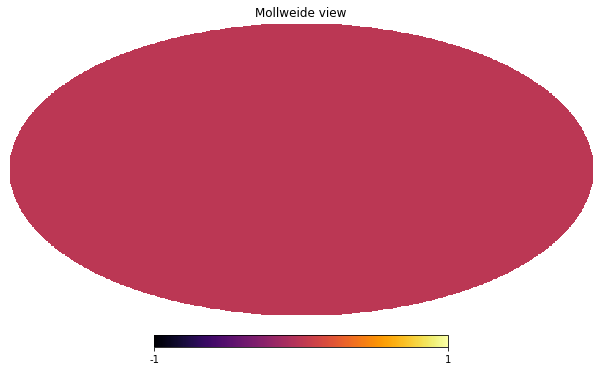

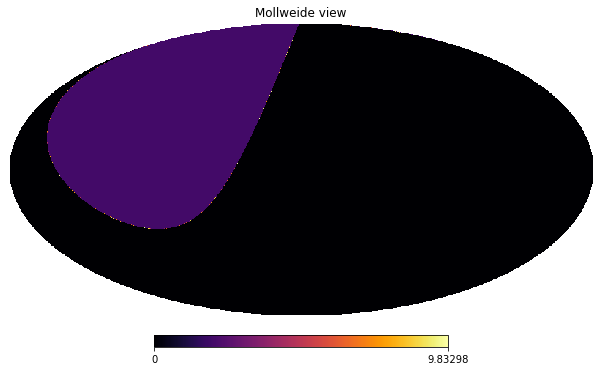

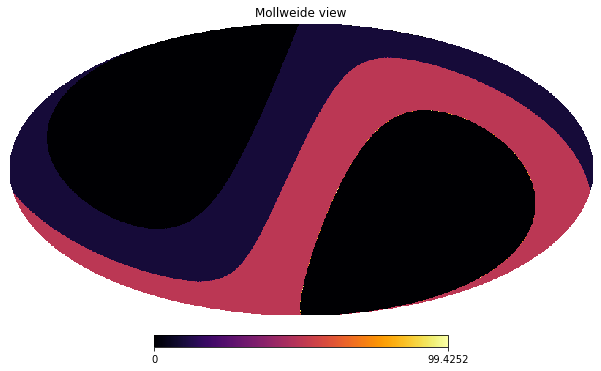

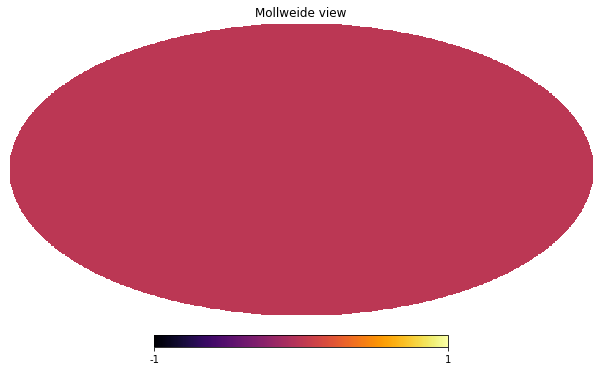

In [10]:
N_reg_scafac = 4
input_map = noise_gal

masks = np.zeros(( len(input_map), N_reg_scafac))

for i in range(N_reg_scafac):

    masks[:,i] = np.where(np.abs(input_map - error_values[i]) <= 0.1  , 1,0 )

#masks[:, -1] = np.where((input_map >= error_values[-2]) & (input_map < error_values[-1]), 1,0 )
    


#There is literally no need to divide into percentiles for this case. Let us just split into the obvious 4 regions

masks_per = np.zeros(( len(input_map), N_reg_scafac))

temp_divider = np.zeros((N_reg_scafac + 1))
print('the temperature dividers are ' , len(temp_divider), ' long ')

temp_divider[0] = np.min(input_map)
temp_divider[-1] = np.max(input_map)

print('The max of the map is ' , temp_divider[-1] )
percentiles = np.linspace(1, 97, int(N_reg_scafac -1 ) )
for i in range(N_reg_scafac - 1):
    print('dividing percentiles are ' , percentiles[i])
    temp_divider[i + 1] = np.percentile(input_map ,  percentiles[i])
        
print('the temperature dividers are ', temp_divider )
for i in range(N_reg_scafac - 1):
    print('values must be between ' ,temp_divider[i] , ' percentile and ' , temp_divider[i+1] )
    masks_per[:,i] = np.where((input_map >= temp_divider[i]) & (input_map < temp_divider[i+1]), 1,0 )

masks_per[:, -1] = np.where((input_map >= temp_divider[-2]) & (input_map < temp_divider[-1]), 1,0 )

    
#take a look to see if everything went well
for i in range(N_reg_scafac):
    hp.visufunc.mollview(np.multiply(input_map, masks[:,i]) , cmap = 'inferno')
    pl.show()
    pl.close()
    
print('----------------------------------------------------------------')
for i in range(N_reg_scafac):
    hp.visufunc.mollview(np.multiply(input_map, masks_per[:,i]) , cmap = 'inferno')
    pl.show()
    pl.close()


#np.save('Masks_ArtificalErrors_at150MHz_' + str(N_reg_scafac) +'_regions_.npy' , masks)




## Results 

## One amplitude scale factor

In [90]:
!open /Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialErrors4_fitwAllSky150_Nscafac_1_60MinObs/analysis/total_comparison.pdf

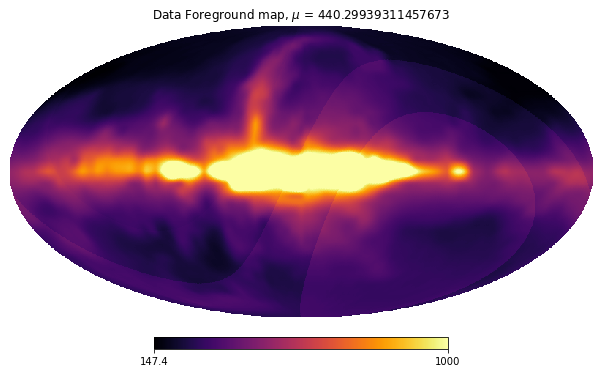

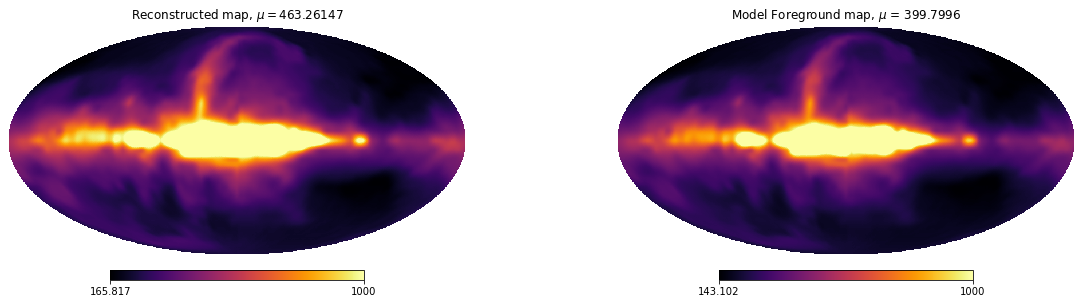

In [91]:
#Reconstruct the maps
amp_scale_factor = 0.115873417361033e1
vmax = 1000
reconstructed_map = amp_scale_factor*allsky_150MHz

mean_original = np.mean(allsky_150MHz)
mean_reconstructed = np.mean(reconstructed_map)
mean_allsky_150MHz_wNoise = np.mean(allsky_150MHz_wNoise)
#hp.visufunc.mollview(reconstructed_map , cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
hp.visufunc.mollview(allsky_150MHz_wNoise , max = vmax, cmap = 'inferno', title = r'Data Foreground map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))


fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(reconstructed_map , max = vmax, hold = True, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
pl.axes(ax2)
hp.visufunc.mollview(allsky_150MHz , max = vmax, hold = True, cmap = 'inferno', title = r'Model Foreground map, $\mu$ = ' + str(mean_original))

pl.show()
pl.close()


## 4 Amplitude Scale Factors

In [1]:
!open /Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialErrors4_fitwAllSky150_Nscafac_4_60MinObs/analysis/total_comparison.pdf

In [ ]:
Dim No.       Mean        Sigma
  1  0.270174713003906E+001 +/-   0.105221369334470E-004
  2  0.735096040756031E+000 +/-   0.566651366791141E-003
  3  0.904644320420731E+000 +/-   0.601652635725865E-003
  4  0.123500392854295E+001 +/-   0.222935741308311E-003
  5  0.144514425587567E+001 +/-   0.653295495197277E-003
  6  0.638524033717330E+002 +/-   0.888069199398616E-001
  7  0.120616070153001E+002 +/-   0.646900865319197E-001
  8  0.725021408794687E+001 +/-   0.352051671843388E-001
  9  0.259997408360098E-001 +/-   0.249475689866218E-006

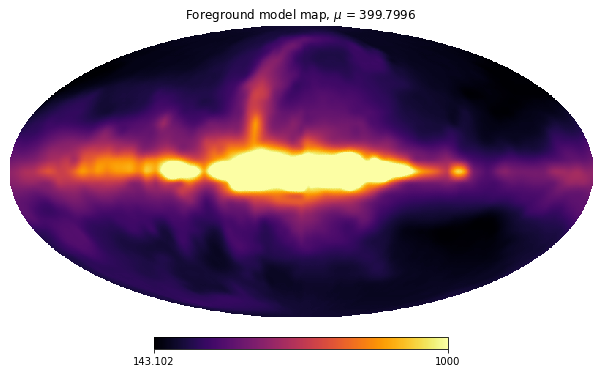

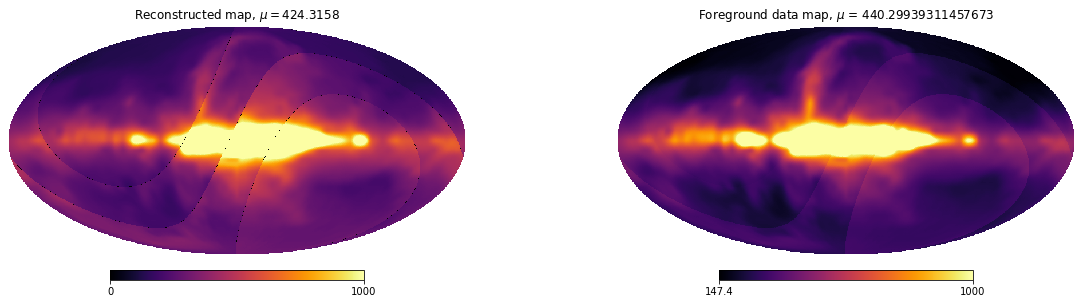

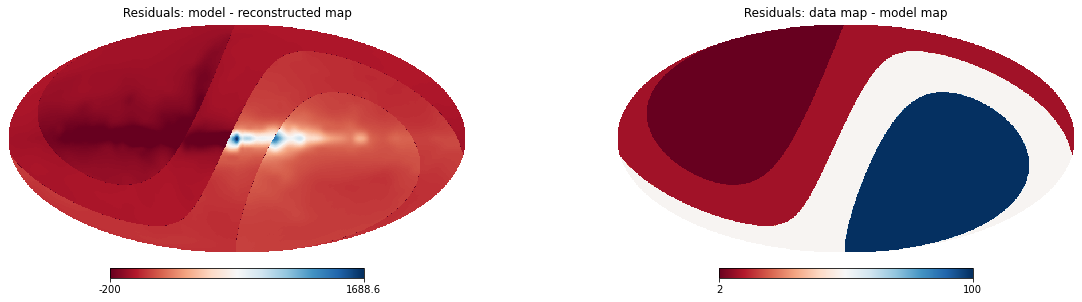

In [89]:
#Reconstruct the maps

#path to errors and maps 
masks = np.load('Masks_ArtificalErrors_at150MHz_4_regions_.npy')
allsky_150MHz_wNoise = allsky_150MHz_wNoise
amp_scale_factors = (0.73509604075603e0, 0.904644320420731e0, 0.123500392854295e1, 0.144514425587567e1 )

#make a reconstructor object
posterior_map = Reconstructor(amp_scale_factors, allsky_150MHz, masks, return_residuals = True)
posterior_map.reconstruct_map()
reconstructed_map = posterior_map.reconstructed_map
residuals  = posterior_map.residuals

mean_original = np.mean(allsky_150MHz)
mean_reconstructed = np.mean(reconstructed_map)
mean_allsky_150MHz_wNoise = np.mean(allsky_150MHz_wNoise)
vmax = 1000
#hp.visufunc.mollview(reconstructed_map , max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
hp.visufunc.mollview(allsky_150MHz , max = vmax, cmap = 'inferno', title = r'Foreground model map, $\mu$ = ' + str(mean_original))
#hp.visufunc.mollview(allsky_150MHz_wNoise ,max = vmax, cmap = 'inferno', title = r'Foreground data map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))
#hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, reconstructed_map) , cmap = 'RdBu', title = r' Residuals: noisy map - reconstructed map ')
#hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz) , cmap = 'RdBu', title = r' Residuals: noisy map - noise free map ')



fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(reconstructed_map , hold = True, max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
pl.axes(ax2)
hp.visufunc.mollview(allsky_150MHz_wNoise ,hold = True, max = vmax, cmap = 'inferno', title = r'Foreground data map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))
pl.show()
pl.close()

fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(np.subtract(reconstructed_map,allsky_150MHz) , min = -200, hold = True, cmap = 'RdBu', title = r' Residuals: model - reconstructed map ')
pl.axes(ax2)
hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz) ,hold = True, cmap = 'RdBu', title = r' Residuals: data map - model map ')
pl.show()
pl.close()

mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)
                                  2.0 418.849 420.849 307.894


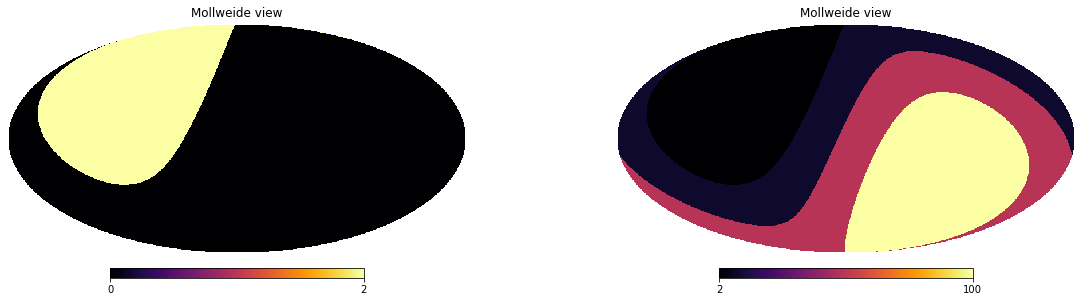

mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)
                                  10.0 412.043 422.043 372.753


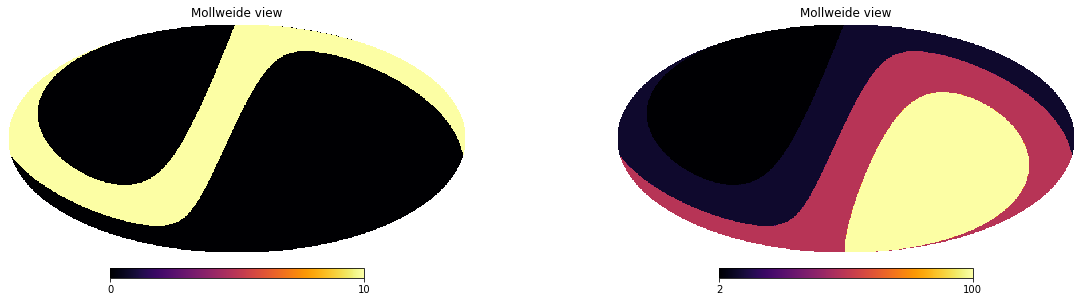

mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)
                                  50.0 428.944 478.944 529.747


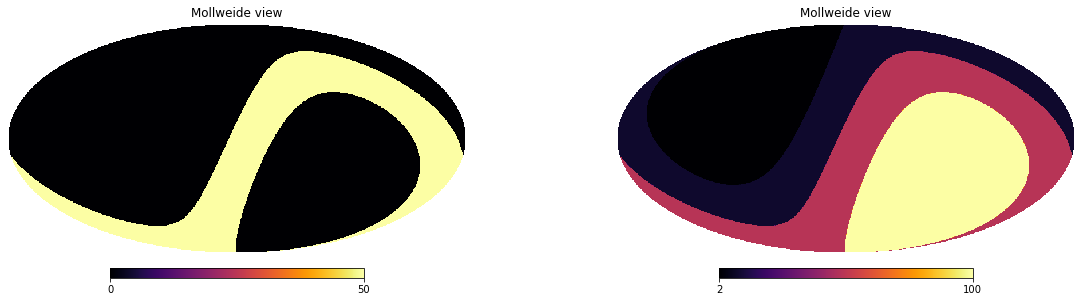

mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)
                                  100.0 339.219 439.219 49.022


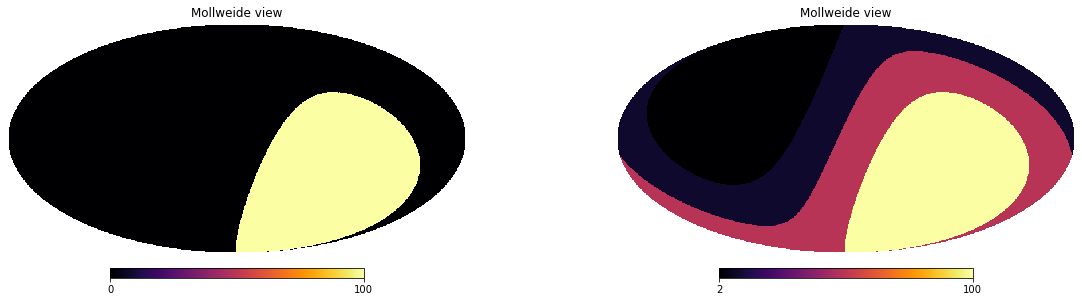

In [84]:
#check to see if 4 masks is consistent
for i in range(masks.shape[1]):
    unmasked_region_errors = np.multiply(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), masks[:,i])
    unmasked_region_originalmap = np.multiply(allsky_150MHz, masks[:,i])
    unmasked_region_datamap = np.multiply(allsky_150MHz_wNoise, masks[:,i])
    unmasked_regions_reconstructed = np.multiply(reconstructed_map, masks[:,i])
    
    mean_nonzero_region_errors = np.mean(unmasked_region_errors[unmasked_region_errors != 0] )
    mean_nonzero_region_originalmap = np.mean(unmasked_region_originalmap[unmasked_region_originalmap != 0] )
    mean_nonzero_region_datamap = np.mean(unmasked_region_datamap[unmasked_region_datamap != 0] )
    mean_nonzero_reigon_reconstructed = np.mean(unmasked_regions_reconstructed[unmasked_regions_reconstructed != 0 ])
    
    print('mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)')
    print('                                 ' , np.round(mean_nonzero_region_errors,3), np.round(mean_nonzero_region_originalmap,3), np.round(mean_nonzero_region_datamap,3), np.round(mean_nonzero_reigon_reconstructed, 3) )
    fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
    pl.axes(ax1)
    hp.visufunc.mollview(np.multiply(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), masks[:,i]), hold = True , cmap = 'inferno')
    pl.axes(ax2)
    hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), hold = True , cmap = 'inferno')
    pl.show()
    pl.close()

## 8 Regions

In [ ]:
#Reconstruct the maps

#path to errors and maps 
path = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/AllSky150wPspecErrors_fitwAllSky150_Nscafac_4_60MinObs/'
masks = np.load(os.path.join(path, 'Masks_150MHzPspecErrors_8_regions_.npy'))
allsky_150MHz_wNoise = np.load(os.path.join(path, 'allsky_150MHz_wAngularPspecErrors.npy'))
amp_scale_factors = (0.828906249955955e0, 0.104338380116944e1, 0.976676071743965e0, 0.915480722748014e0,  0.107749877920151e1,0.104196973733910e1, 0.100250226219780e1,0.112047656968608e1) 

#make a reconstructor object
posterior_map = Reconstructor(amp_scale_factors, allsky_150MHz, masks, return_residuals = True)
posterior_map.reconstruct_map()
reconstructed_map = posterior_map.reconstructed_map
residuals  = posterior_map.residuals

mean_original = np.mean(allsky_150MHz)
mean_reconstructed = np.mean(reconstructed_map)
mean_allsky_150MHz_wNoise = np.mean(allsky_150MHz_wNoise)
vmax = 800
#hp.visufunc.mollview(reconstructed_map , max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
hp.visufunc.mollview(allsky_150MHz , max = vmax, cmap = 'inferno', title = r'Foreground model map, $\mu$ = ' + str(mean_original))
#hp.visufunc.mollview(allsky_150MHz_wNoise ,max = vmax, cmap = 'inferno', title = r'Foreground data map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))
#hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, reconstructed_map) , cmap = 'RdBu', title = r' Residuals: noisy map - reconstructed map ')
#hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz) , cmap = 'RdBu', title = r' Residuals: noisy map - noise free map ')



fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(reconstructed_map , hold = True, max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
pl.axes(ax2)
hp.visufunc.mollview(allsky_150MHz_wNoise ,hold = True, max = vmax, cmap = 'inferno', title = r'Foreground data map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))
pl.show()
pl.close()

fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(np.subtract(reconstructed_map,allsky_150MHz) , hold = True, cmap = 'RdBu', title = r' Residuals: model - reconstructed map ')
pl.axes(ax2)
hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz) ,hold = True, cmap = 'RdBu', title = r' Residuals: data map - model map ')
pl.show()
pl.close()

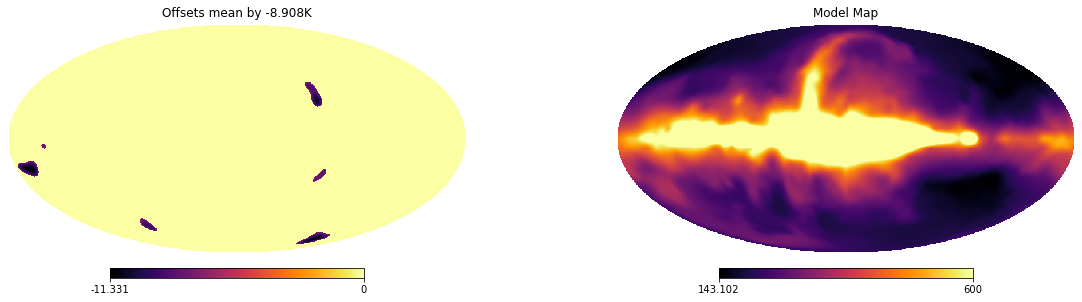

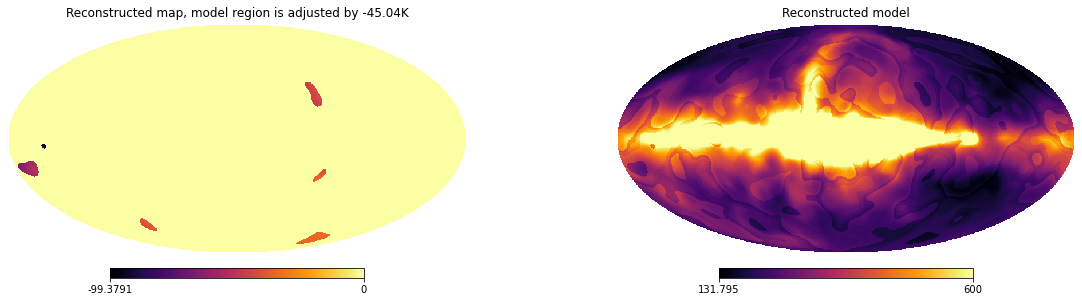

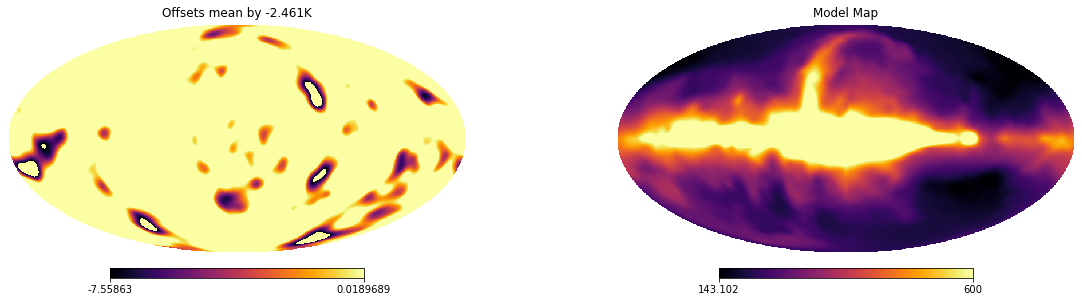

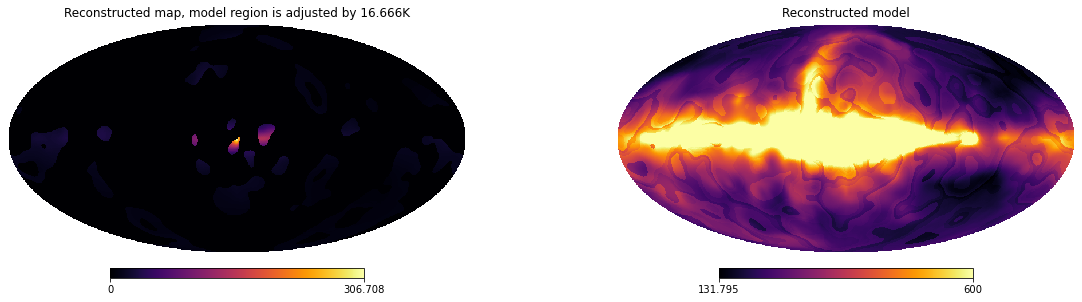

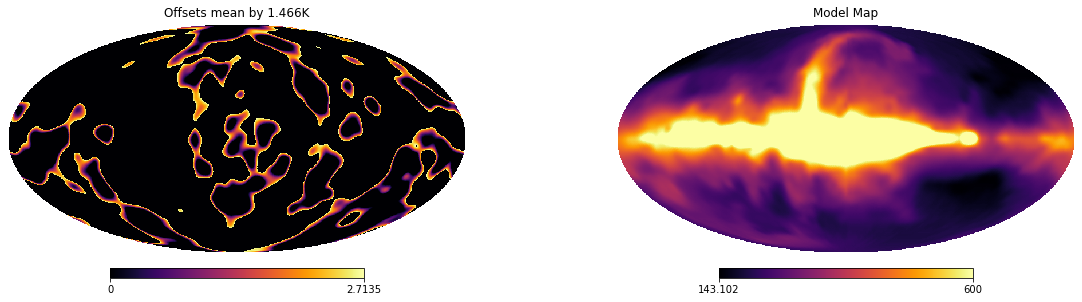

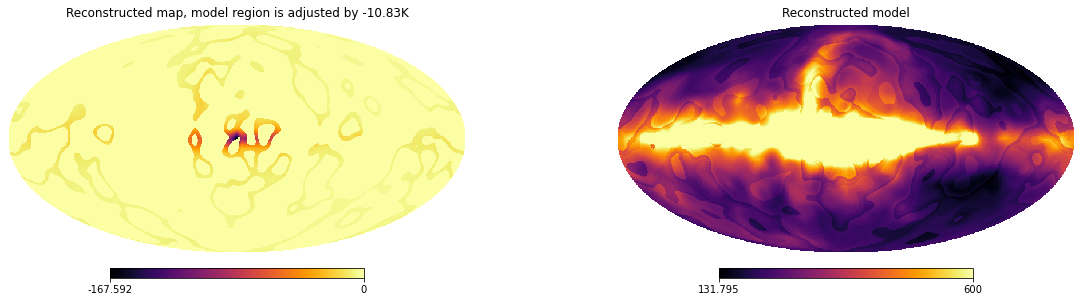

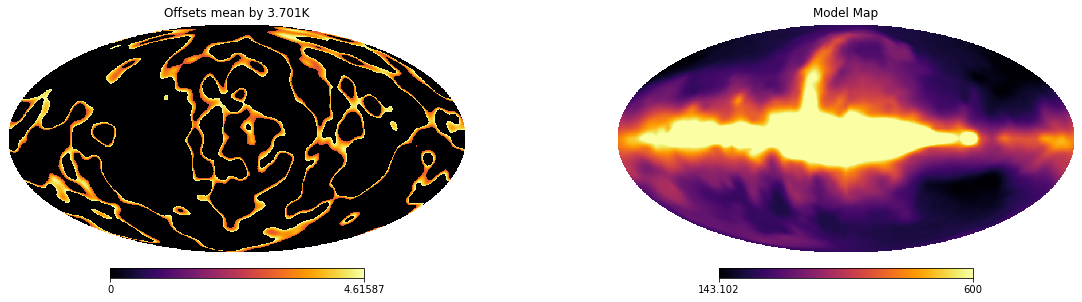

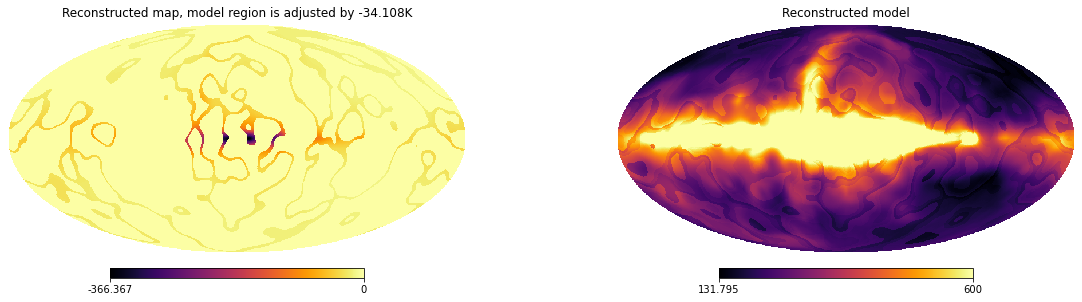

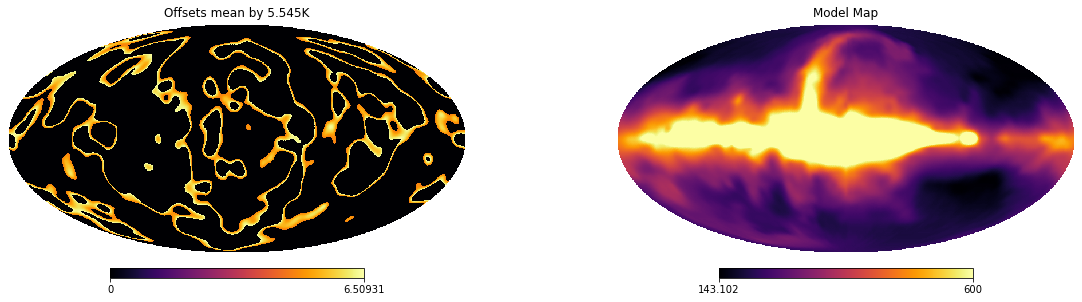

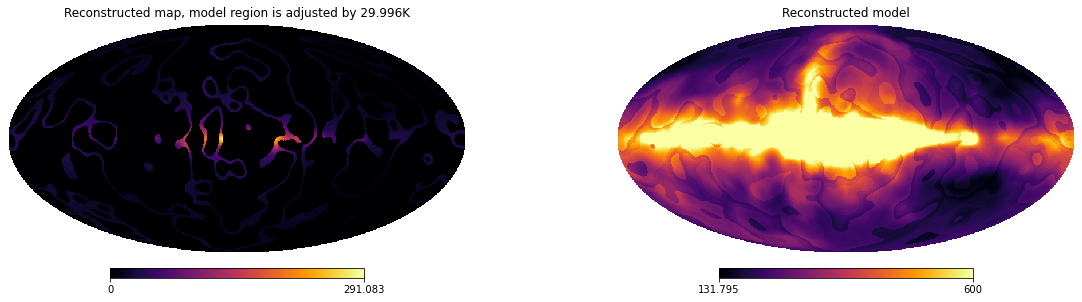

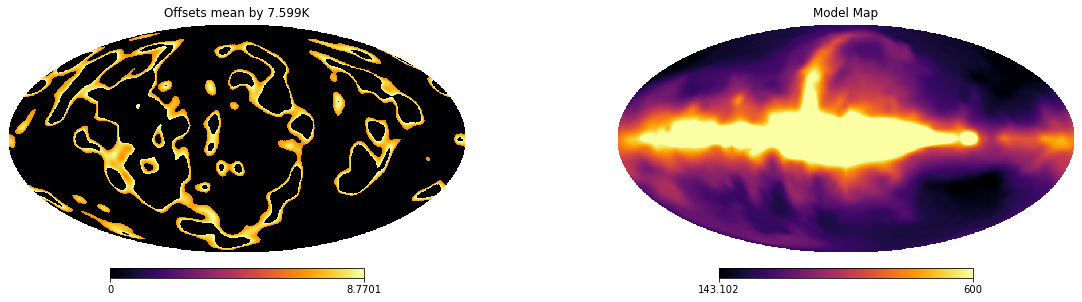

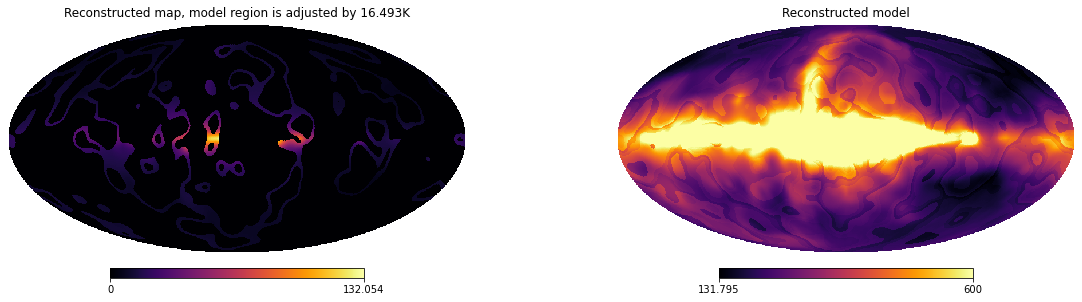

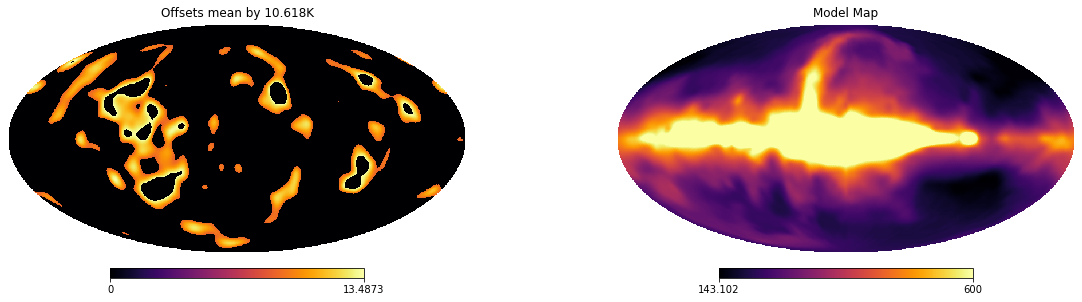

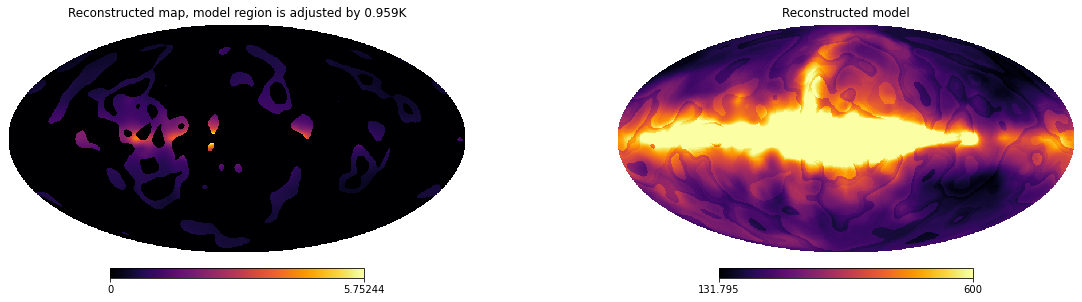

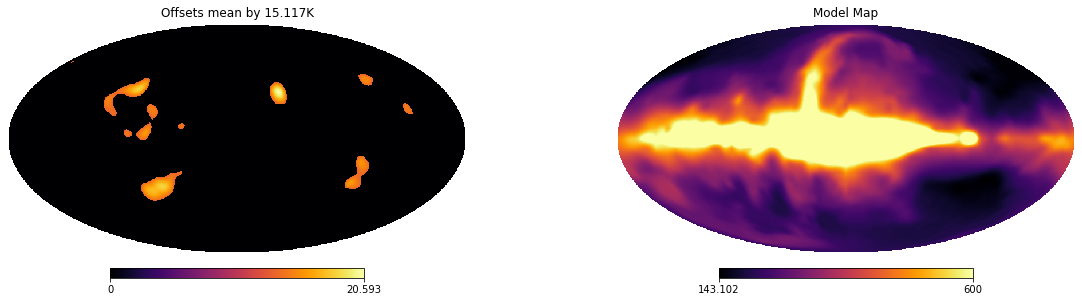

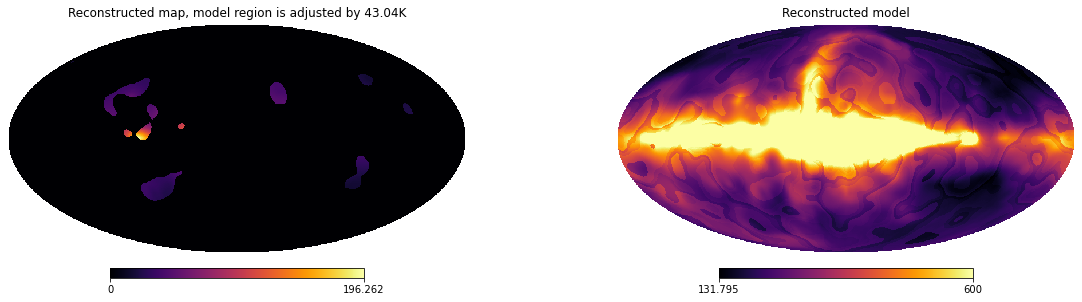

In [55]:
for i in range(masks.shape[1]):
    unmasked_region_errors = np.multiply(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), masks[:,i])
    unmasked_region_originalmap = np.multiply(allsky_150MHz, masks[:,i])
    unmasked_region_datamap = np.multiply(allsky_150MHz_wNoise, masks[:,i])
    unmasked_regions_reconstructed = np.multiply(reconstructed_map, masks[:,i])
    
    mean_nonzero_region_errors = np.mean(unmasked_region_errors[unmasked_region_errors != 0] )
    mean_nonzero_region_originalmap = np.mean(unmasked_region_originalmap[unmasked_region_originalmap != 0] )
    mean_nonzero_region_datamap = np.mean(unmasked_region_datamap[unmasked_region_datamap != 0] )
    mean_nonzero_reigon_reconstructed = np.mean(unmasked_regions_reconstructed[unmasked_regions_reconstructed != 0 ])
    
    #print('mean of unmasked regions in : (errors) , (original map), (data map) , (reconstruced_map)')
    #print('                                 ' , np.round(mean_nonzero_region_errors,3), np.round(mean_nonzero_region_originalmap,3), np.round(mean_nonzero_region_datamap,3), np.round(mean_nonzero_reigon_reconstructed, 3) )
    fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
    pl.axes(ax1)
    hp.visufunc.mollview(np.multiply(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), masks[:,i]), title = r'Offsets mean by ' + str(np.round(mean_nonzero_region_errors,3)) +'K', hold = True , cmap = 'inferno')
    pl.axes(ax2)
    #hp.visufunc.mollview(np.subtract(allsky_150MHz_wNoise, allsky_150MHz), title = 'Entire Error map ', hold = True , cmap = 'inferno')
    hp.visufunc.mollview(allsky_150MHz, max = 600, title = 'Model Map', hold = True , cmap = 'inferno')
    pl.show()
    pl.close()
    fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
    pl.axes(ax1)
    hp.visufunc.mollview(unmasked_regions_reconstructed - unmasked_region_originalmap, title = r'Reconstructed map, model region is adjusted by ' +str(np.round(mean_nonzero_reigon_reconstructed -mean_nonzero_region_originalmap ,3)) +'K' , hold = True , cmap = 'inferno')
    pl.axes(ax2)
    hp.visufunc.mollview(reconstructed_map, title = 'Reconstructed model', max = 600, hold = True , cmap = 'inferno')
    pl.show()
    pl.close()
    
    

# Scaled Error (not ADDED error) - for a scale factor model!


[10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.          2.58428981  2.          2.          2.
  2.          2.          2.          2.          2.          2.
  2.          2.          2.          5.62601828 10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.          3.41817747  2.
  2.          2.          2.          2.          2.          2.
  2.          2.          2.          2.          2.          2.
  2.          4.74051635 10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.          4.31851594  2.
  2.          2.          2.          2.          2.          2.
  2.          2.         

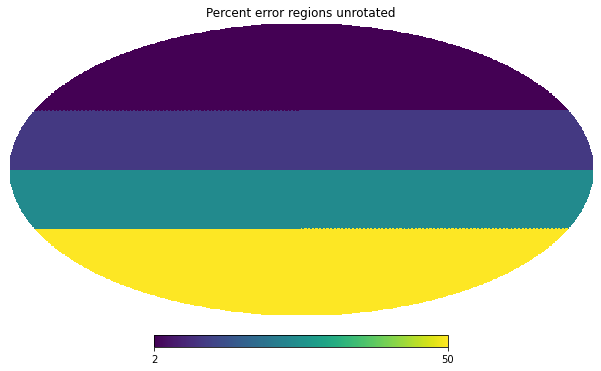

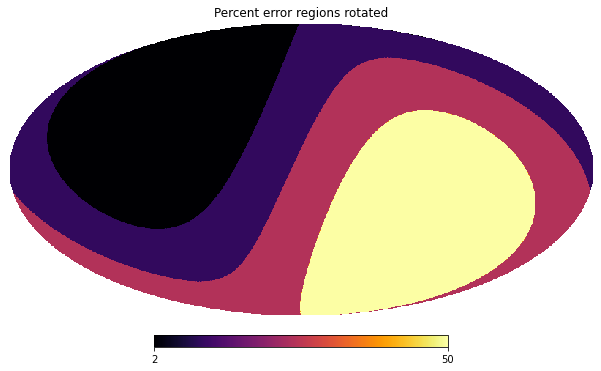

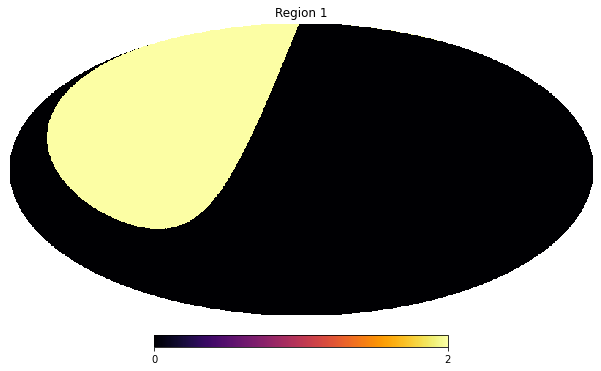

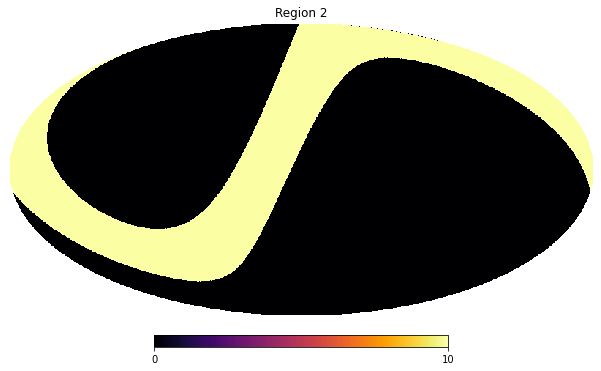

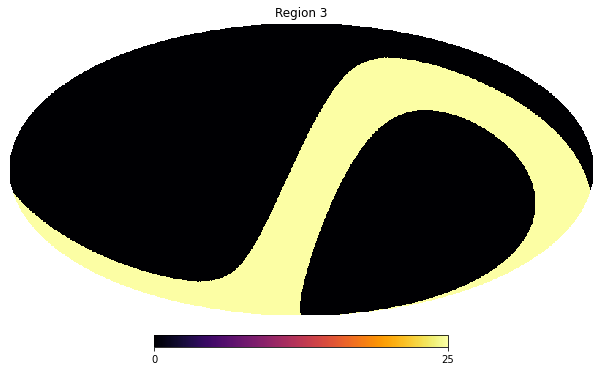

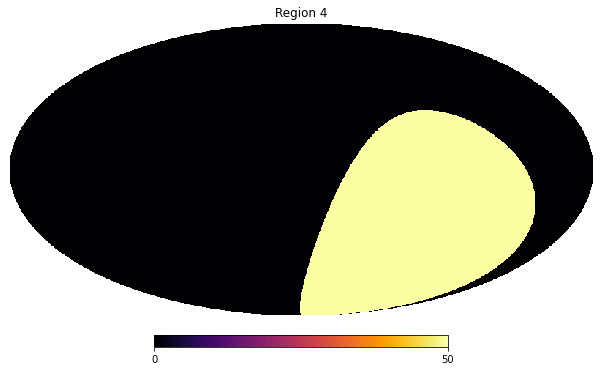

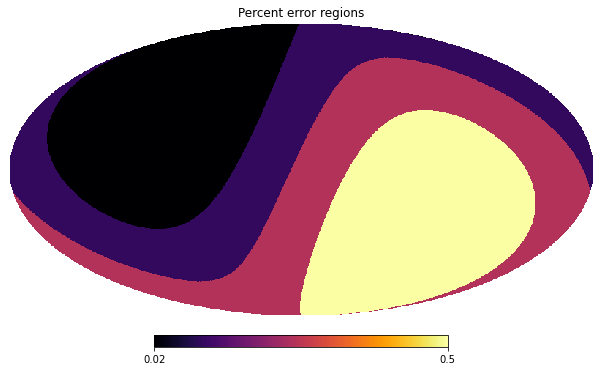

In [62]:
#Re do all the above steps
from healpy import rotator

percent_noise_regions = np.zeros_like((allsky_150MHz))

delta_pix = int(len(allsky_150MHz)/4.)

percent_error_values = (2,10, 25, 50)
percent_error_values = np.array(percent_error_values)

for i in range(4):
    percent_noise_regions[i*delta_pix: (i+1)*delta_pix] = percent_error_values[i]
    
r = rotator.Rotator(coord=['E','G'])

noise_gal = r.rotate_map_pixel(percent_noise_regions)
hp.visufunc.mollview(percent_noise_regions ,   title = "Percent error regions unrotated")

hp.visufunc.mollview(noise_gal ,   title = "Percent error regions rotated", cmap = 'inferno')

print(noise_gal[100:200])
#let us degenerately unsmooth this map because the rotator has smoothed the edges

noise_gal[noise_gal <= 6 ] = 2
noise_gal[(noise_gal > 6) & (noise_gal < 10) ] = 10

noise_gal[(noise_gal > 10) & (noise_gal <= 17.5) ] = 10
noise_gal[(noise_gal > 17.5) & (noise_gal < 25) ] = 25

noise_gal[(noise_gal > 25) & (noise_gal <= 37.5) ] = 25
noise_gal[(noise_gal > 37.5) & (noise_gal < 50) ] = 50

noise_gal[noise_gal >= 50 ] = 50




for i in range(len(percent_error_values)  ):
    #check
    hp.visufunc.mollview(np.where( noise_gal == percent_error_values[i] , noise_gal,0 ) ,  title = "Region " + str(i + 1), cmap = 'inferno') 
#make them percent fluctuations 

print('-------------------------------------------')

print(noise_gal[100:200])
noise_gal = noise_gal/100.
hp.visufunc.mollview(noise_gal ,  title = "Percent error regions", cmap = 'inferno' )



## Multiply pertubation map with base map

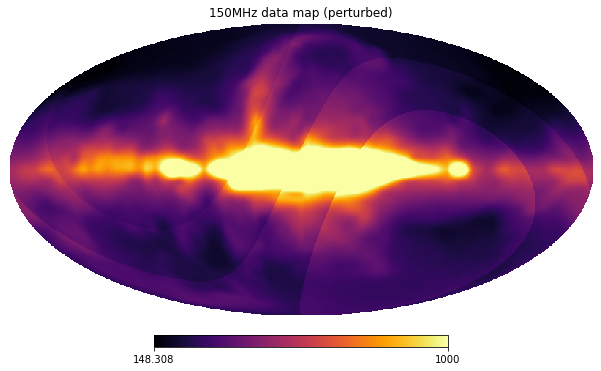

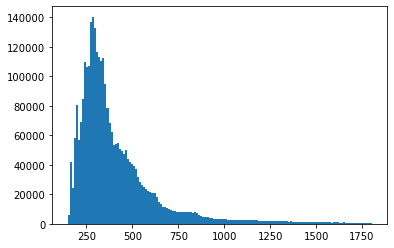

Mean of the noisy map is 481.41763618845516 compared to the original 399.7996


In [12]:
#150Mhz  + noise
allsky_150MHz_data= np.add(np.multiply(allsky_150MHz, noise_gal) , allsky_150MHz)

hp.visufunc.mollview(allsky_150MHz_data , cmap = 'inferno', max = 1000, title = '150MHz data map (perturbed)')
pl.show()
pl.close()
pl.hist(allsky_150MHz_data, bins = np.linspace(np.min(allsky_150MHz_data),np.max(allsky_150MHz_data)/5., 150))
pl.show()
pl.close()

print('Mean of the noisy map is ' + str(np.mean(allsky_150MHz_data)) + ' compared to the original ' + str(np.mean(allsky_150MHz)) )

#save noise and original
#np.save('allsky_150MHz_wArtificialAmplitudeErrors_4Reg.npy', allsky_150MHz_data)
#np.save('allsky_150MHz.npy', allsky_150MHz)
#np.save('ArtificialAmplitudeErrors_4reg.npy', noise_gal)


## Make absolute error map (and masks) - Test it as a prior - Does it work as well as fractional errors?

the temperature dividers are  15  long 
The max of the map is  1803.9647216796875
dividing percentiles are  1.0
dividing percentiles are  9.0
dividing percentiles are  17.0
dividing percentiles are  25.0
dividing percentiles are  33.0
dividing percentiles are  41.0
dividing percentiles are  49.0
dividing percentiles are  57.0
dividing percentiles are  65.0
dividing percentiles are  73.0
dividing percentiles are  81.0
dividing percentiles are  89.0
dividing percentiles are  97.0
the temperature dividers are  [   2.90800812    3.58516113    5.74996948    9.28097107   16.29265991
   24.96279472   33.92695618   49.13529205   62.23879623   78.82577515
   97.00634003  114.03025055  160.69891357  338.64611816 1803.96472168]
values must be between  2.9080081176757915  percentile and  3.5851611328124875
values must be between  3.5851611328124875  percentile and  5.749969482421875
values must be between  5.749969482421875  percentile and  9.28097106933592
values must be between  9.28097106933592

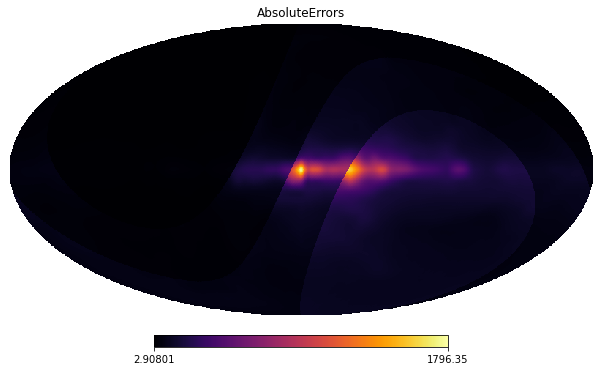

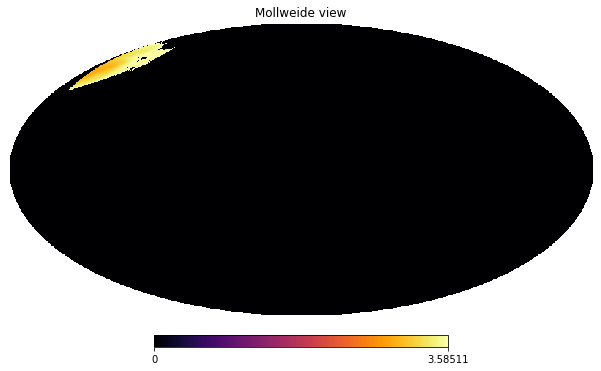

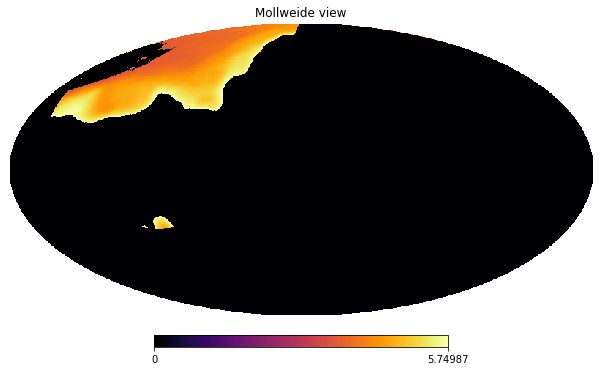

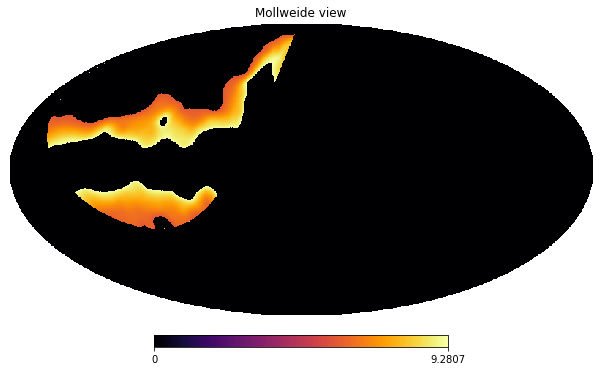

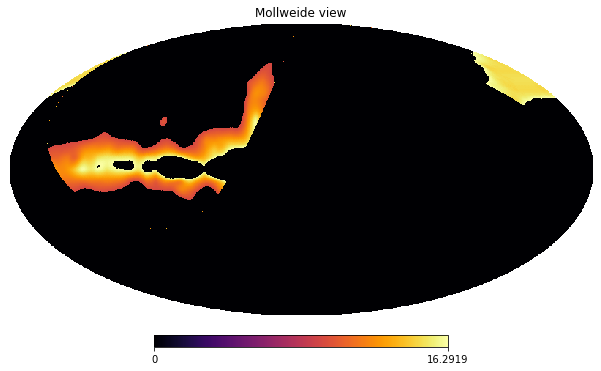

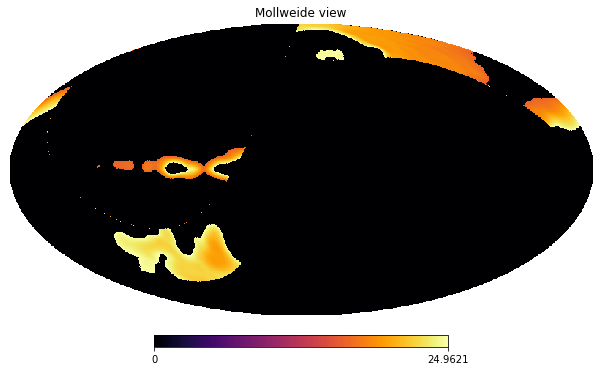

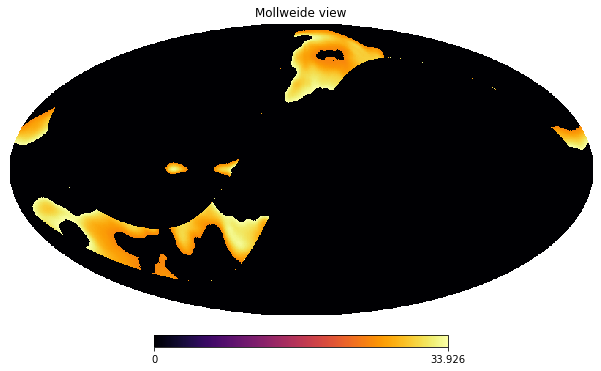

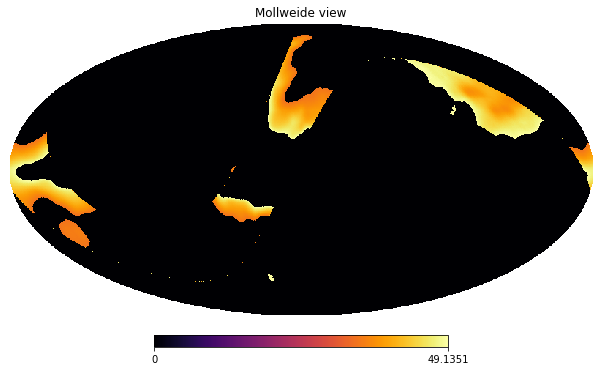

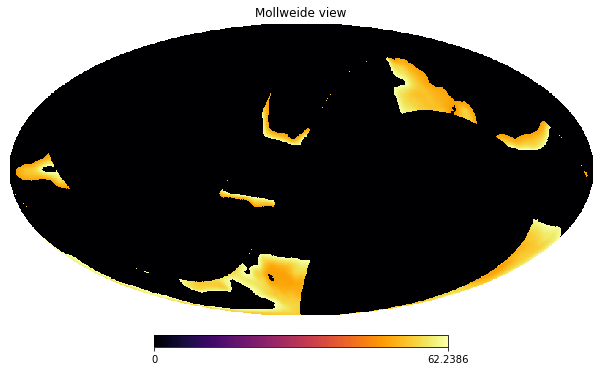

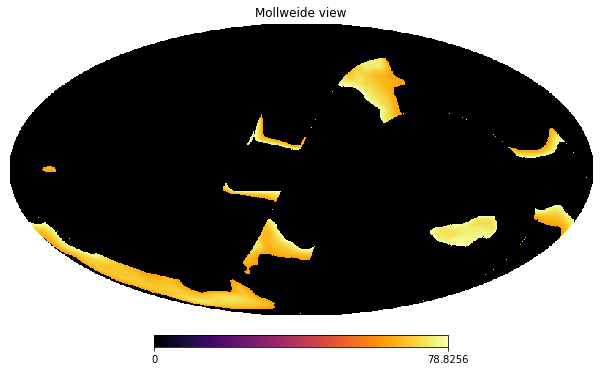

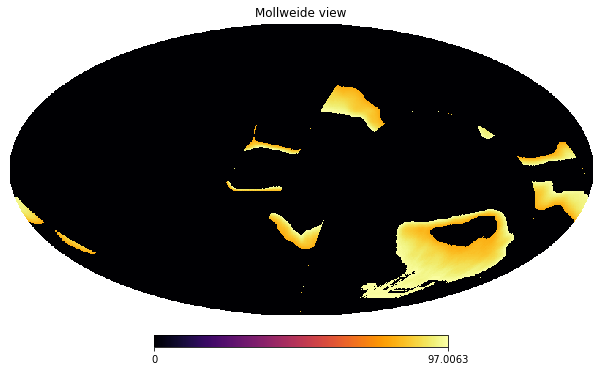

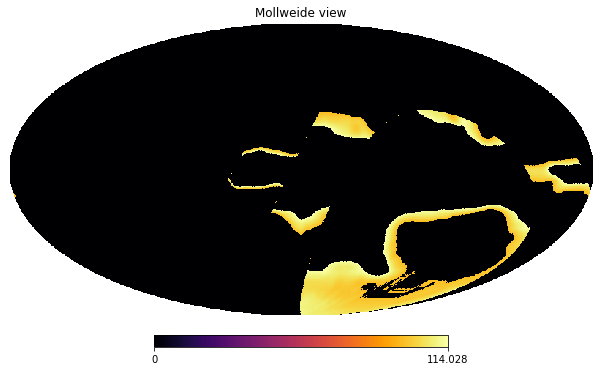

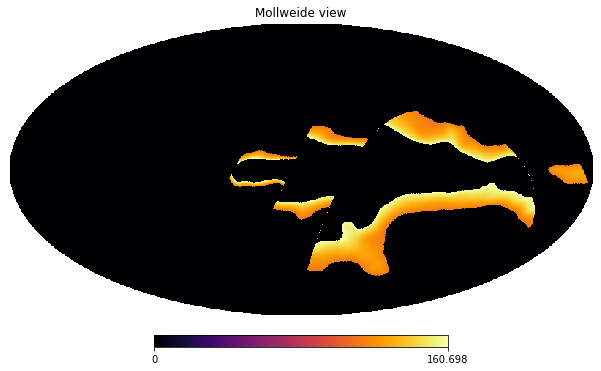

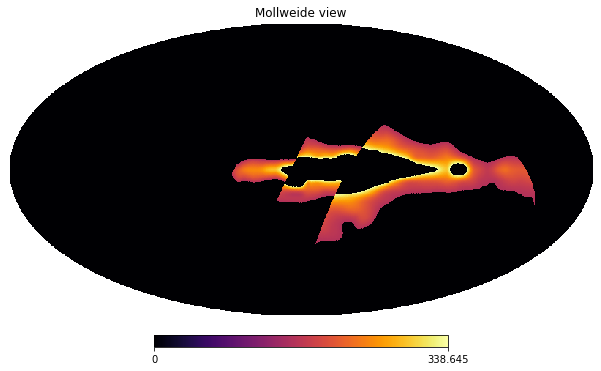

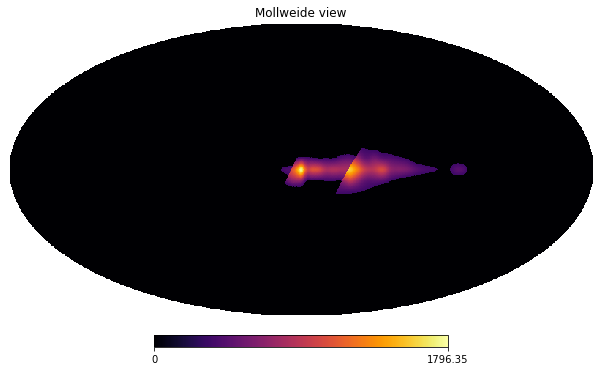

In [75]:
AbsoluteErrors = np.subtract(allsky_150MHz_data , allsky_150MHz) 

hp.visufunc.mollview(AbsoluteErrors , cmap = 'inferno',  title = 'AbsoluteErrors')

N_reg_scafac = 14
input_map = AbsoluteErrors
masks = np.zeros(( len(input_map), N_reg_scafac))

temp_divider = np.zeros((N_reg_scafac + 1))
print('the temperature dividers are ' , len(temp_divider), ' long ')

temp_divider[0] = np.min(input_map)
temp_divider[-1] = np.max(input_map)

print('The max of the map is ' , temp_divider[-1] )
percentiles = np.linspace(1, 97, int(N_reg_scafac -1 ) )
for i in range(N_reg_scafac - 1):
    print('dividing percentiles are ' , percentiles[i])
    temp_divider[i + 1] = np.percentile(input_map ,  percentiles[i])
        
print('the temperature dividers are ', temp_divider )
for i in range(N_reg_scafac - 1):
    print('values must be between ' ,temp_divider[i] , ' percentile and ' , temp_divider[i+1] )
    masks[:,i] = np.where((input_map >= temp_divider[i]) & (input_map < temp_divider[i+1]), 1,0 )

masks[:, -1] = np.where((input_map >= temp_divider[-2]) & (input_map < temp_divider[-1]), 1,0 )

for i in range(N_reg_scafac):
    hp.visufunc.mollview(np.multiply(input_map, masks[:,i]) , cmap = 'inferno')
    pl.show()
    pl.close()

#PERCENTILE MATTERS!!!

## Generate Masks

the temperature dividers are  6  long 
The max of the map is  0.5
dividing percentiles are  1.0
dividing percentiles are  33.0
dividing percentiles are  65.0
dividing percentiles are  97.0
the temperature dividers are  [0.02 0.02 0.1  0.25 0.5  0.5 ]
values must be between  0.02  percentile and  0.02
values must be between  0.02  percentile and  0.1
values must be between  0.1  percentile and  0.25
values must be between  0.25  percentile and  0.5
between  0.5  and  0.5


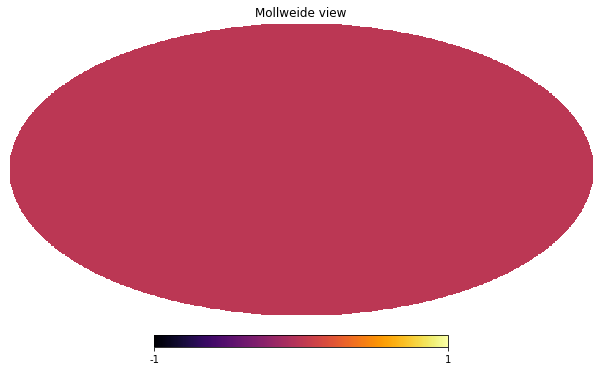

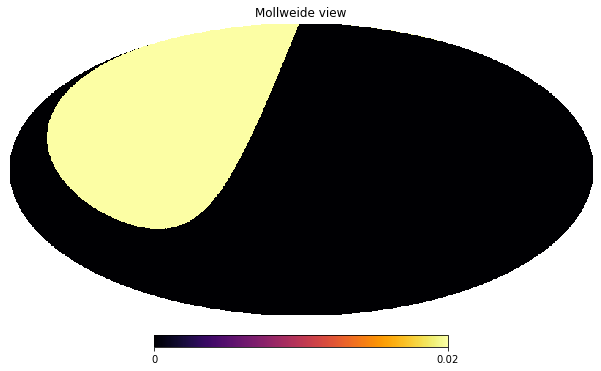

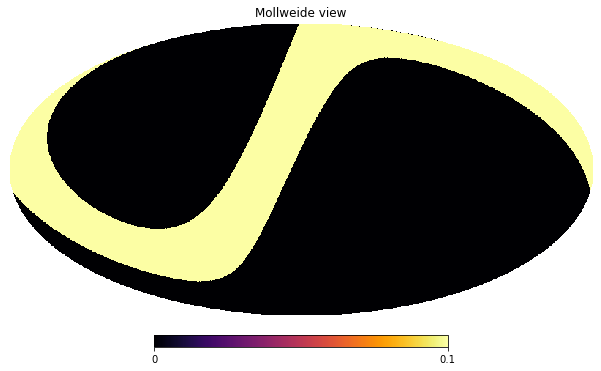

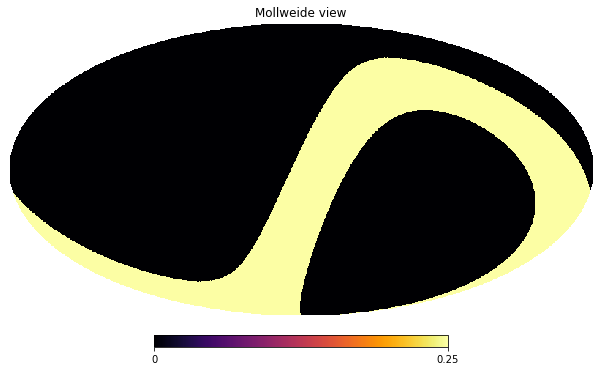

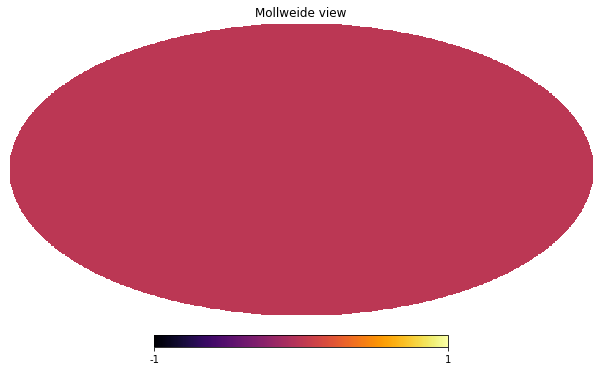

In [88]:
N_reg_scafac = 5
input_map = noise_gal
masks = np.zeros(( len(input_map), N_reg_scafac))

'''
for i in range(N_reg_scafac):

    #masks[:,i] = np.where(np.abs(100*input_map - percent_error_values[i]) <= 0.1  , 1,0 )
    
    masks[:,i] = np.where((100*noise_gal == percent_error_values[i]), 1 , 0)
    

#masks[:, -1] = np.where((input_map >= error_values[-2]) & (input_map < error_values[-1]), 1,0 )
'''   


#There is literally no need to divide into percentiles for this case. Let us just split into the obvious 4 regions

temp_divider = np.zeros((N_reg_scafac + 1))
print('the temperature dividers are ' , len(temp_divider), ' long ')

temp_divider[0] = np.min(input_map)
temp_divider[-1] = np.max(input_map)

print('The max of the map is ' , temp_divider[-1] )
percentiles = np.linspace(1, 97, int(N_reg_scafac -1 ) )
for i in range(N_reg_scafac - 1):
    print('dividing percentiles are ' , percentiles[i])
    temp_divider[i + 1] = np.percentile(input_map ,  percentiles[i])
        
print('the temperature dividers are ', temp_divider )
for i in range(N_reg_scafac - 1):
    print('values must be between ' ,temp_divider[i] , ' percentile and ' , temp_divider[i+1] )
    masks[:,i] = np.where((input_map >= temp_divider[i]) & (input_map < temp_divider[i+1]), 1,0 )

#masks[:, -1] = np.where((input_map >= temp_divider[-2]) & (input_map < temp_divider[-1]), 1,0 )

print('between ', temp_divider[-2] , ' and ' , temp_divider[-1] )

    
#take a look to see if everything went well
for i in range(N_reg_scafac):
    hp.visufunc.mollview(np.multiply(input_map, masks[:,i]) , cmap = 'inferno')
    pl.show()
    pl.close()


#np.save('Masks_ArtificalErrorsAmplitude_at150MHz_' + str(N_reg_scafac) +'_regions_.npy' , masks)




# Results

## One Amplitude Scale Factor

In [35]:
!open /Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialAmplitudeErrors_fitwAllSky150_Nscafac_1_60MinObs/analysis/total_comparison.pdf

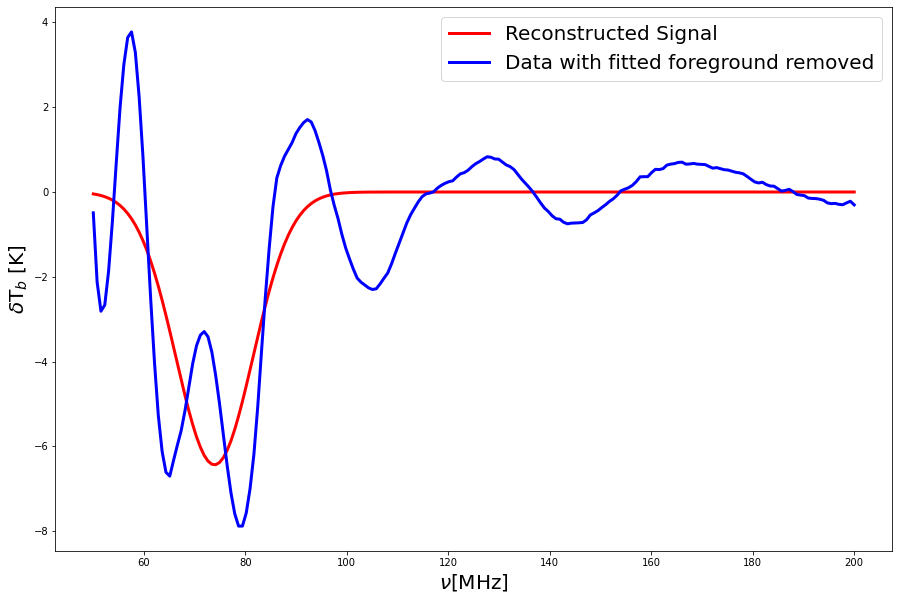

In [39]:
h5pyfile = h5py.File('/Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialAmplitudeErrors_fitwAllSky150_Nscafac_1_60MinObs/analysis/analysis_arrays.hdf5', 'r')

nu_fine = h5pyfile['nu_fine'][:]
reconstructed_signal = h5pyfile['reconstructed_signal'][:]
comparison_data_with_foreground_removed = h5pyfile['comparison_data_with_foreground_removed'][:]


#obs_minus_fg = np.load('/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/Memo_AllSky_wPSpecNoise_Nscafac_0_60min_obs/analysis/plot_data.npy')

freq = np.linspace(50, 250, 151)

pl.figure(figsize = (15,10))
pl.plot(nu_fine, reconstructed_signal , color = 'r', linewidth = 3, label = 'Reconstructed Signal')
pl.plot(nu_fine, comparison_data_with_foreground_removed , color = 'blue', linewidth = 3, label = 'Data with fitted foreground removed')
pl.xlabel(r'$\nu$[MHz]', fontsize = 20)
pl.ylabel(r'$\delta$T$_b$ [K]', fontsize = 20)
pl.legend(fontsize = 20)
pl.show()
pl.close()



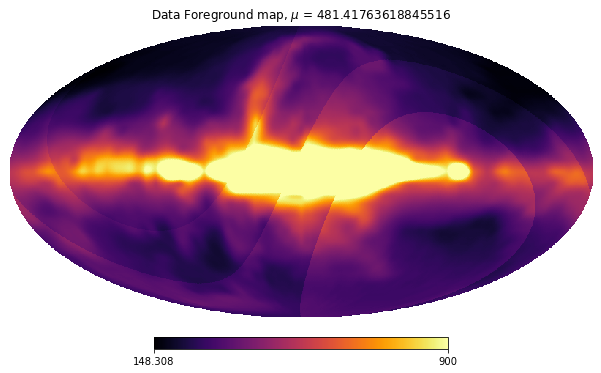

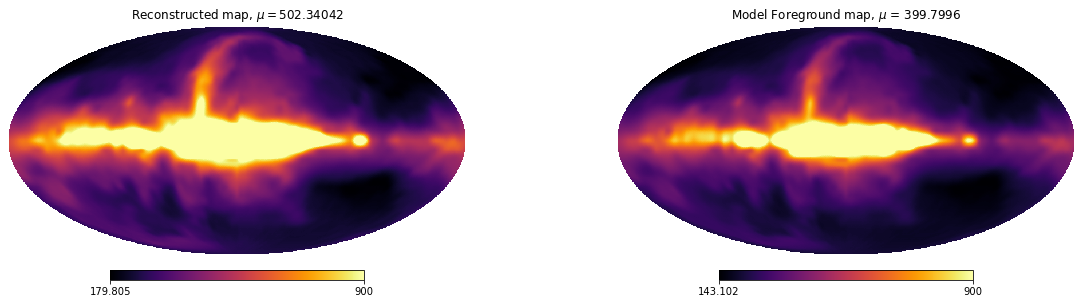

In [28]:
#Reconstruct the maps
amp_scale_factor = 0.125648142427266e1
vmax = 900
reconstructed_map = amp_scale_factor*allsky_150MHz

mean_original = np.mean(allsky_150MHz)
mean_reconstructed = np.mean(reconstructed_map)
mean_allsky_150MHz_wNoise = np.mean(allsky_150MHz_data)
#hp.visufunc.mollview(reconstructed_map , cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
hp.visufunc.mollview(allsky_150MHz_data , max = vmax, cmap = 'inferno', title = r'Data Foreground map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))


fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(reconstructed_map , max = vmax, hold = True, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
pl.axes(ax2)
hp.visufunc.mollview(allsky_150MHz , max = vmax, hold = True, cmap = 'inferno', title = r'Model Foreground map, $\mu$ = ' + str(mean_original))

pl.show()
pl.close()


## Four amplitude scale factors

In [46]:
!open /Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialAmplitudeErrors_fitwAllSky150_Nscafac_4_60MinObs/analysis/total_comparison.pdf

In [ ]:
Dim No.       Mean        Sigma
  1  0.270003102162023E+001 +/-   0.877970530749399E-005
  2  0.101980742915601E+001 +/-   0.453816979834451E-003
  3  0.110042983086189E+001 +/-   0.460675979744829E-003
  4  0.125737483326823E+001 +/-   0.191430973053266E-003
  5  0.150813034490184E+001 +/-   0.585702510977073E-003
  6  0.586961228421603E+002 +/-   0.597748420994633E+001
  7  0.185426814036354E+002 +/-   0.408940730844763E+001
  8  0.105308287375080E+000 +/-   0.366621748566943E-001
  9  0.251553161020527E-001 +/-   0.552131046720753E-003


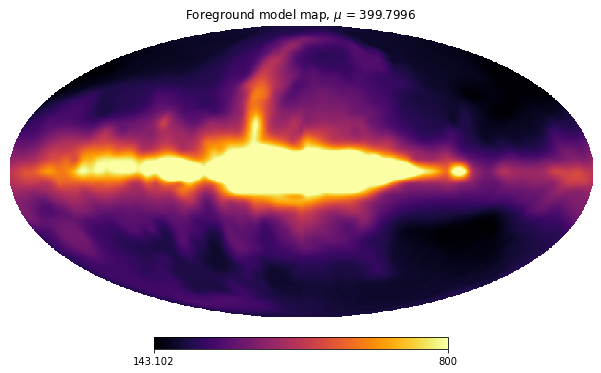

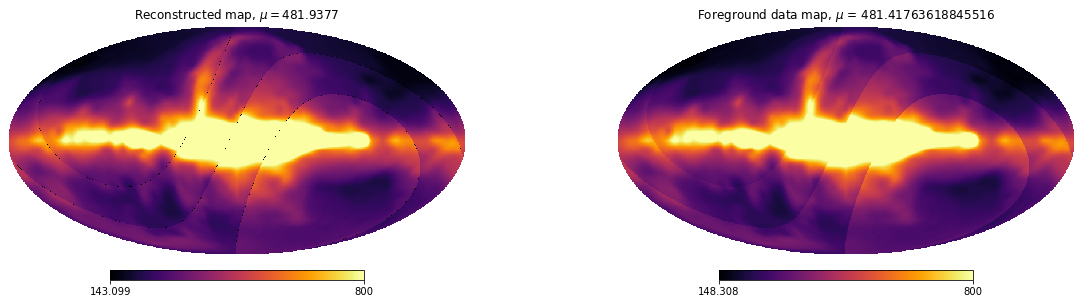

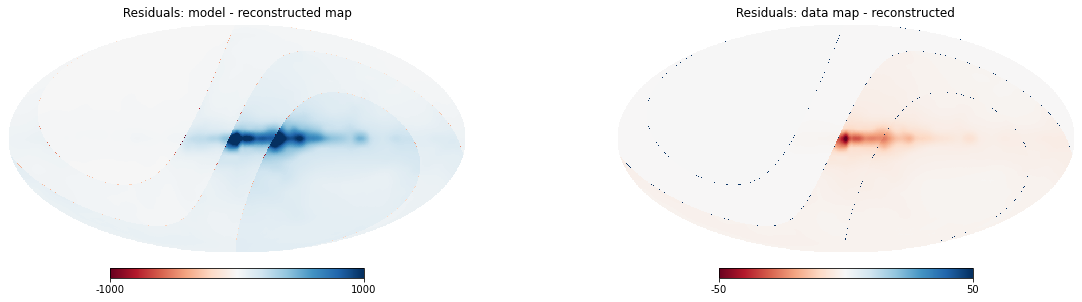

In [43]:
#Reconstruct the maps
data_map = np.load('/Volumes/Tubster/REACH/150MHz/ArtificialErrors/ArtificialAmplitudeErrors_fitwAllSky150_Nscafac_4_60MinObs/allsky_150MHz_wArtificialAmplitudeErrors_4Reg.npy')
amp_scale_factors = (0.101980742915601e1, 0.110042983086189e1, 0.125737483326823e1, 0.150813034490184e1 )

#make a reconstructor object
posterior_map = Reconstructor(amp_scale_factors, allsky_150MHz, masks, return_residuals = True)
posterior_map.reconstruct_map()
reconstructed_map = posterior_map.reconstructed_map
residuals  = posterior_map.residuals

mean_original = np.mean(allsky_150MHz)
mean_reconstructed = np.mean(reconstructed_map)
mean_allsky_150MHz_wNoise = np.mean(allsky_150MHz_data)
vmax = 800
#hp.visufunc.mollview(reconstructed_map , max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
hp.visufunc.mollview(allsky_150MHz , max = vmax, cmap = 'inferno', title = r'Foreground model map, $\mu$ = ' + str(mean_original))




fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(reconstructed_map , min = np.min(allsky_150MHz), hold = True, max = vmax, cmap = 'inferno', title = r'Reconstructed map, $\mu = $' + str(mean_reconstructed))
pl.axes(ax2)
hp.visufunc.mollview(allsky_150MHz_data ,hold = True, max = vmax, cmap = 'inferno', title = r'Foreground data map, $\mu$ = ' + str(mean_allsky_150MHz_wNoise))
pl.show()
pl.close()

fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
pl.axes(ax1)
hp.visufunc.mollview(np.subtract(reconstructed_map,allsky_150MHz) , min = -1000, max = 1000,hold = True, cmap = 'RdBu', title = r' Residuals: model - reconstructed map ')
pl.axes(ax2)
hp.visufunc.mollview(np.subtract(data_map, reconstructed_map) ,max = 50, min = -50, hold = True, cmap = 'RdBu', title = r' Residuals: data map - reconstructed ')
pl.show()
pl.close()

/bin/bash: -c: line 0: syntax error near unexpected token `attachment:/users/michael/Desktop/Beam.png'
/bin/bash: -c: line 0: ` /users/michael/Desktop/Beam.png (attachment:/users/michael/Desktop/Beam.png)'


 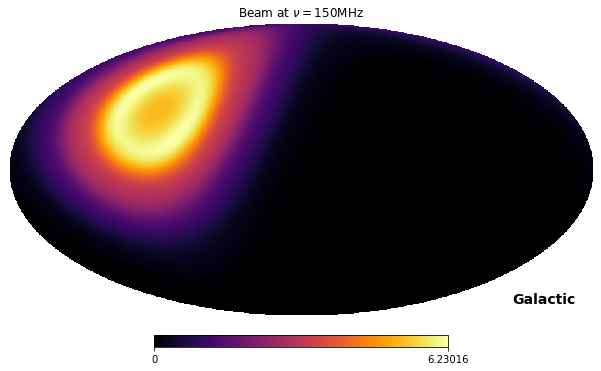

# A different type of Artificial Error Test Case

## Percentile Genereated Artificial Errors

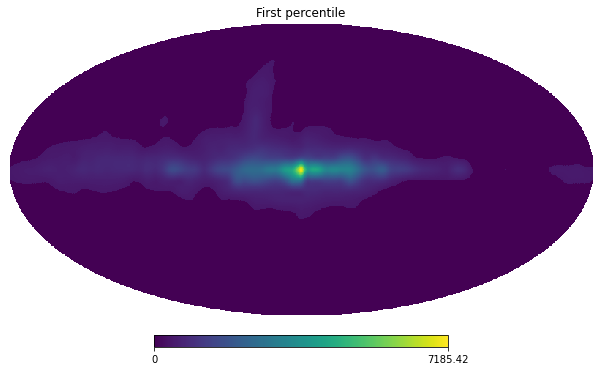

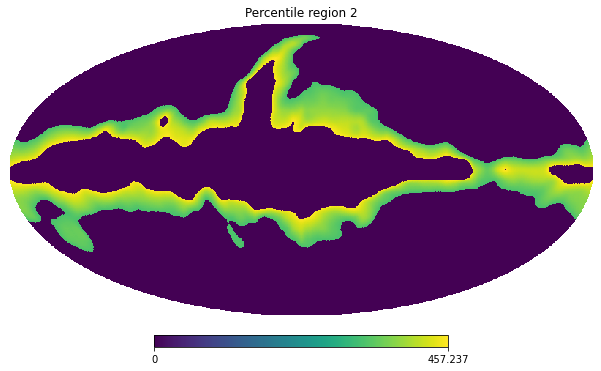

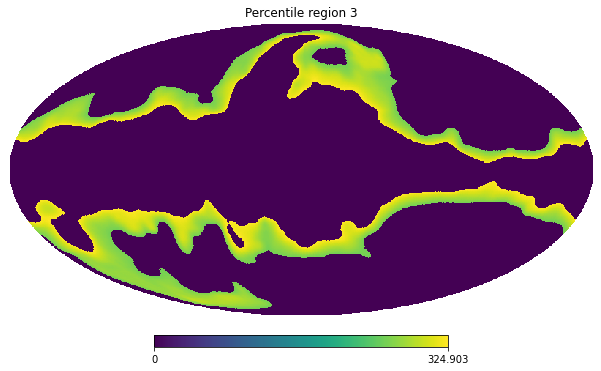

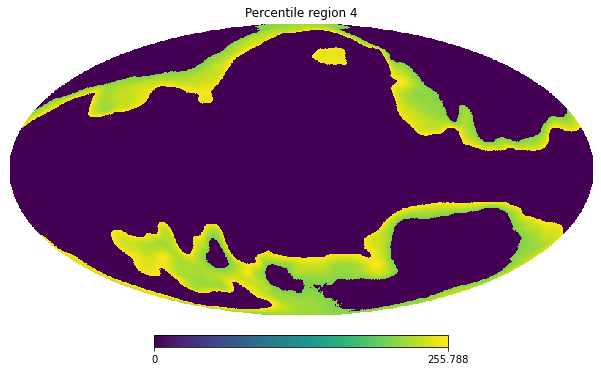

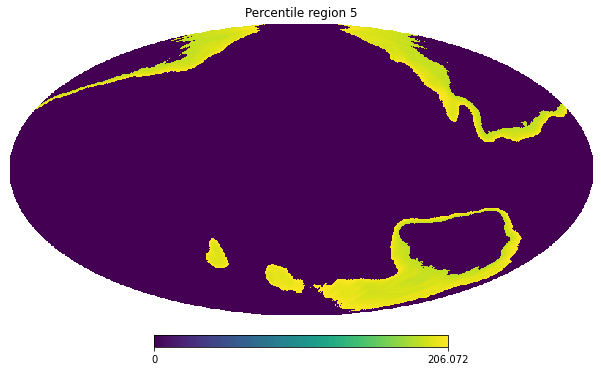

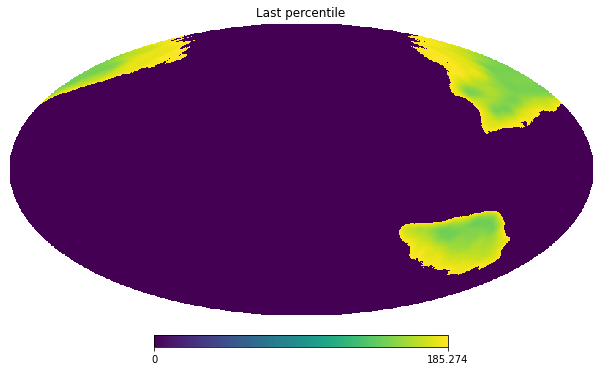

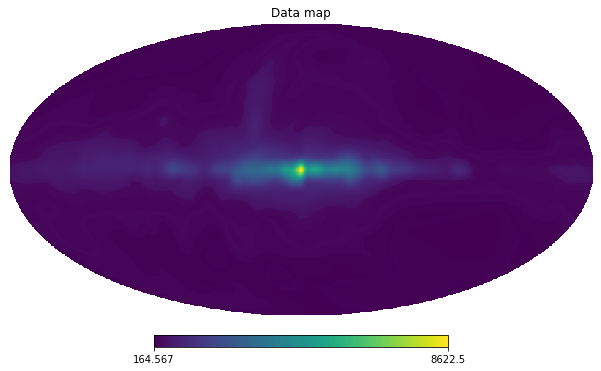

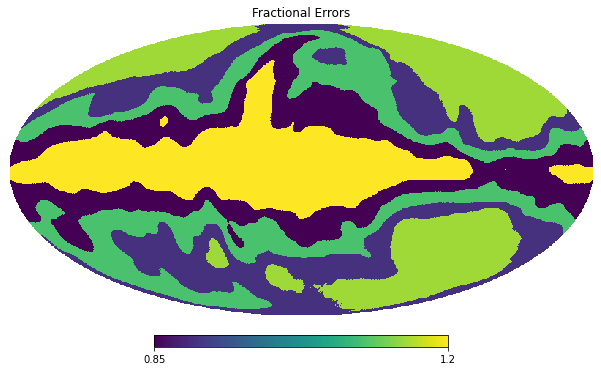

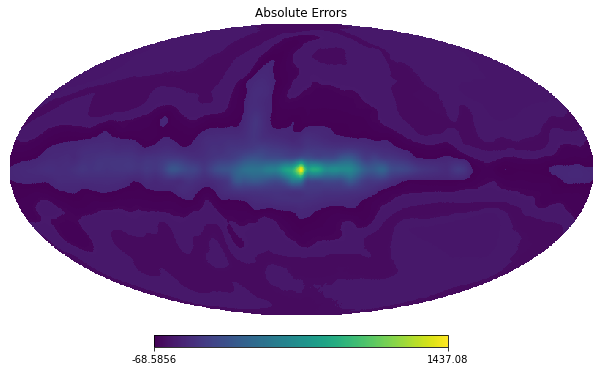

In [222]:
Basemap_150MHz = allsky_150MHz
DataMap_wErrors = allsky_150MHz.copy()

#How many regions do we want?
n_regions = 4
delta_percentiles = 100./n_regions



Mask = np.zeros_like(Basemap_150MHz)

#make perturbed error map
#base
percentiles = (75,50, 25)
scafacs = (1.5, 1.25, 0.75, 0.5)

#to test are they different??
#scafacs = (1.05, 1.01,1.3, 1.05)

#What we're actually going to use
percentiles = (80, 60, 40, 20, 10)
scafacs = (1.2, 0.85, 1.1, 0.9, 1.15)

Mask[Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[0])] = 1
hp.visufunc.mollview(np.multiply(Mask, Basemap_150MHz) , title = "First percentile")
DataMap_wErrors[Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[0])] = Basemap_150MHz[Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[0])]*scafacs[0]

for i in range(len(percentiles) -1):
    Mask = np.zeros_like(Basemap_150MHz)
    Mask[(Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[i+1])) & (Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[i])) ] = 1
    hp.visufunc.mollview(np.multiply(Mask, Basemap_150MHz) , title = "Percentile region " + str(i+2))
    DataMap_wErrors[(Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[i+1])) & (Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[i])) ] = Basemap_150MHz[(Basemap_150MHz >= np.percentile(Basemap_150MHz, percentiles[i+1])) & (Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[i])) ]*scafacs[i+1]

    #Mask = np.zeros_like(Basemap_150MHz)
    #Mask[(Basemap_150MHz >= np.percentile(Basemap_150MHz, 25)) & (Basemap_150MHz < np.percentile(Basemap_150MHz, 50)) ] = 1
    #hp.visufunc.mollview(np.multiply(Mask, Basemap_150MHz) , title = "All Sky 150MHz")
    #DataMap_wErrors[(Basemap_150MHz >= np.percentile(Basemap_150MHz, 25)) & (Basemap_150MHz < np.percentile(Basemap_150MHz, 50)) ]   = 0.75*Basemap_150MHz[(Basemap_150MHz >= np.percentile(Basemap_150MHz, 25)) & (Basemap_150MHz < np.percentile(Basemap_150MHz, 50)) ]


Mask = np.zeros_like(Basemap_150MHz)
Mask[(Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[-1])) ] = 1
hp.visufunc.mollview(np.multiply(Mask, Basemap_150MHz) , title = "Last percentile")
DataMap_wErrors[(Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[-1])) ]  = scafacs[-1]*Basemap_150MHz[(Basemap_150MHz < np.percentile(Basemap_150MHz, percentiles[-1])) ]


hp.visufunc.mollview(DataMap_wErrors, title = "Data map")


frac_errors = np.true_divide(DataMap_wErrors, Basemap_150MHz)
hp.visufunc.mollview(frac_errors, title = "Fractional Errors")


abs_errors = np.subtract(DataMap_wErrors , Basemap_150MHz)
hp.visufunc.mollview(abs_errors, title = "Absolute Errors")










Jump in percentile increments of 16.666666666666668
First region consists of points less than   -50.99893188476562
Region 1 consists of points between -50.99893188476562 and -22.240829467773438
Region 2 consists of points between -22.240829467773438 and 26.59039306640625
Region 3 consists of points between 26.59039306640625 and 29.199778238932296
Region 4 consists of points between 29.199778238932296 and 100.00235493977871
Last region consists of points greate than  100.00235493977871
Jump in percentile increments of 16.666666666666668
First region consists of points less than   0.8500000238418579
Region 1 consists of points between 0.8500000238418579 and 0.8999999761581421
Region 2 consists of points between 0.8999999761581421 and 1.100000023841858
Region 3 consists of points between 1.100000023841858 and 1.149999976158142
Region 4 consists of points between 1.149999976158142 and 1.2000000476837158
Last region consists of points greate than  1.2000000476837158


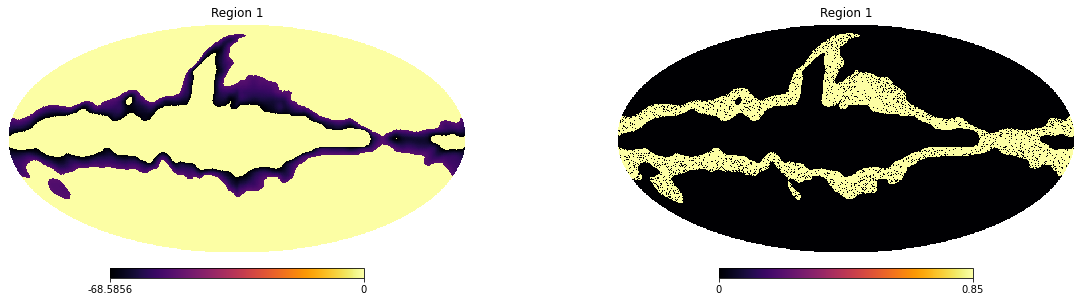

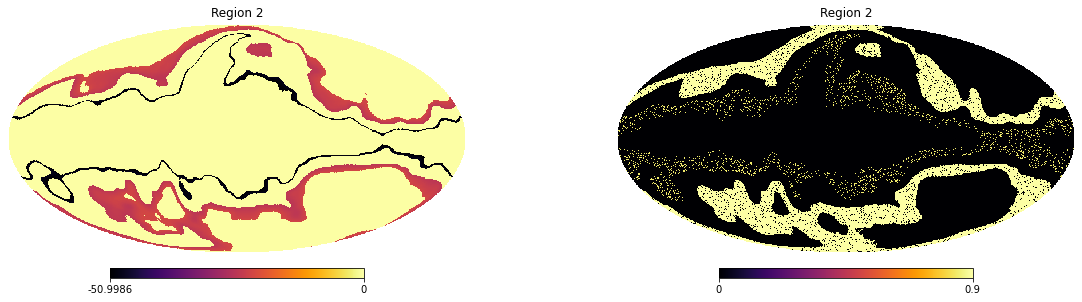

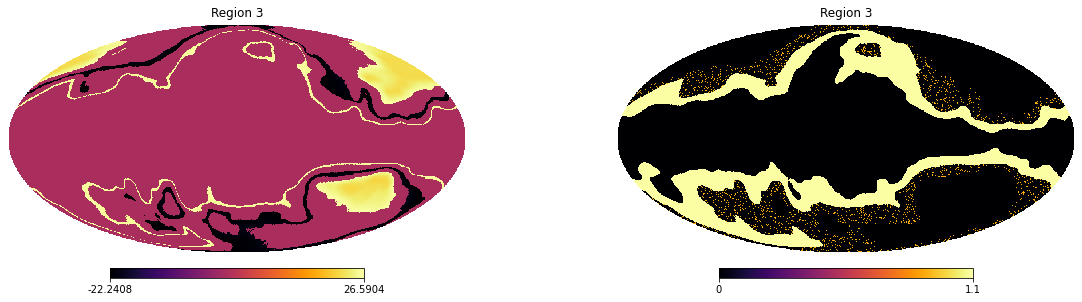

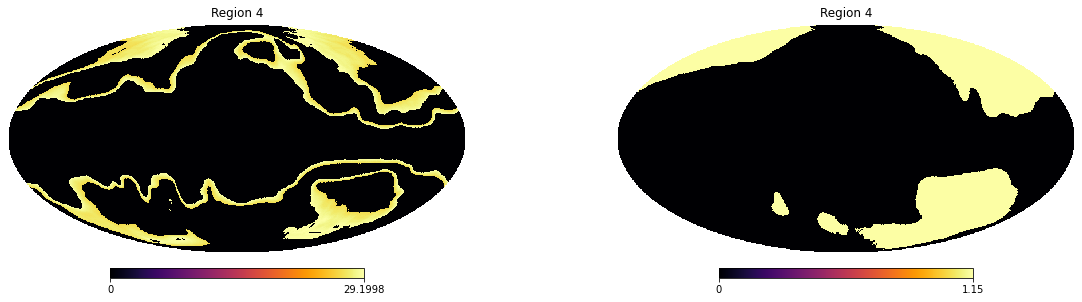

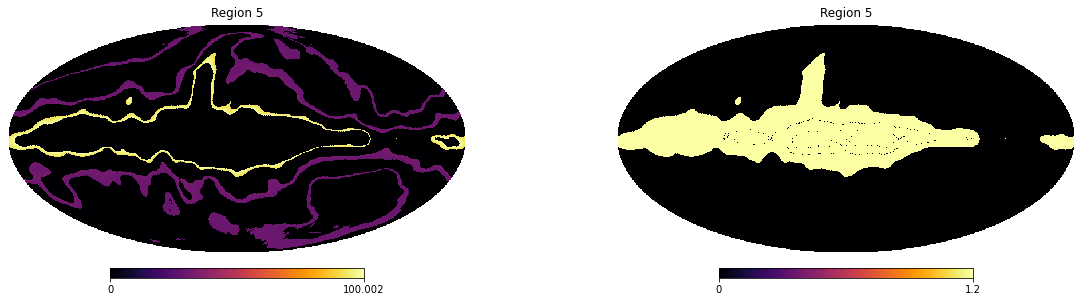

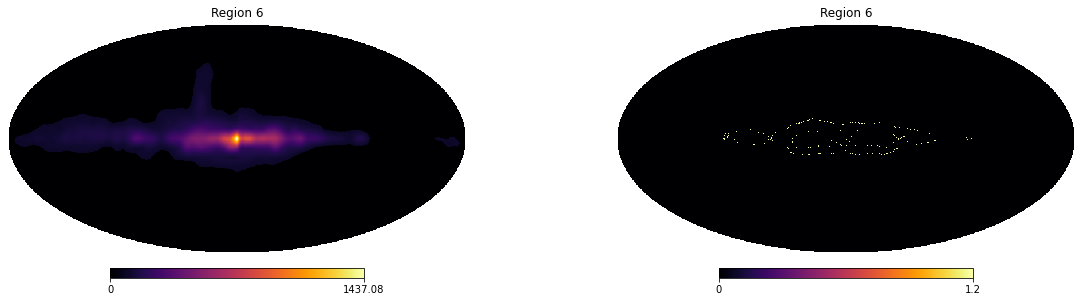

In [223]:
from generate_masks import GenerateMasks

n_regions_in_masks = 6
AbsMasks = GenerateMasks(n_regions_in_masks, abs_errors)
masks_abs_errors = AbsMasks.masks
for i in range(N_reg_scafac):
    break
    hp.visufunc.mollview(np.multiply(input_map, masks_abs_errors[:,i]) , title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()
    
    
FracMasks = GenerateMasks(n_regions_in_masks, frac_errors)
masks_frac_errors = FracMasks.masks
for i in range(N_reg_scafac):
    break
    hp.visufunc.mollview(np.multiply(input_map, masks_frac_errors[:,i]) , title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()
    


#take a look to see if everything went well
for i in range(n_regions_in_masks):
    #break

    
    fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
    pl.axes(ax1)
    hp.visufunc.mollview(np.multiply(abs_errors, masks_abs_errors[:,i]) , hold = True, title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.axes(ax2)
    hp.visufunc.mollview(np.multiply(frac_errors, masks_frac_errors[:,i]) , hold = True, title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()







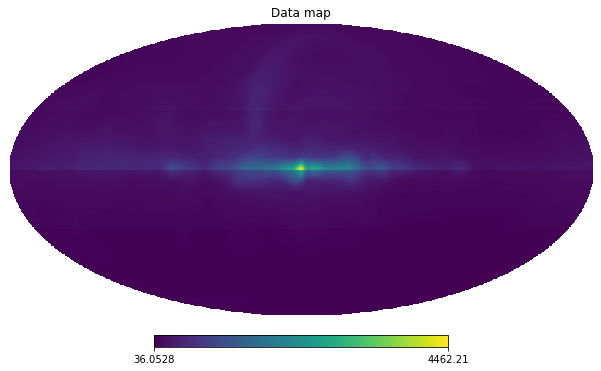

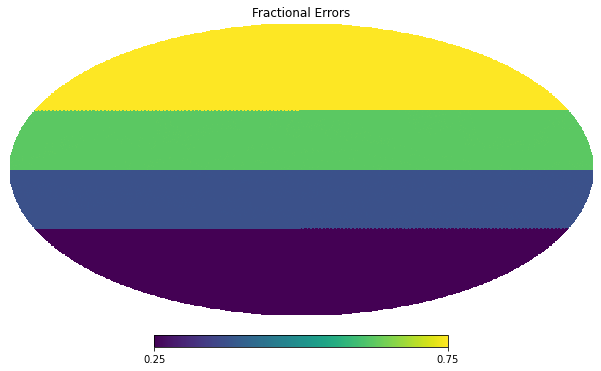

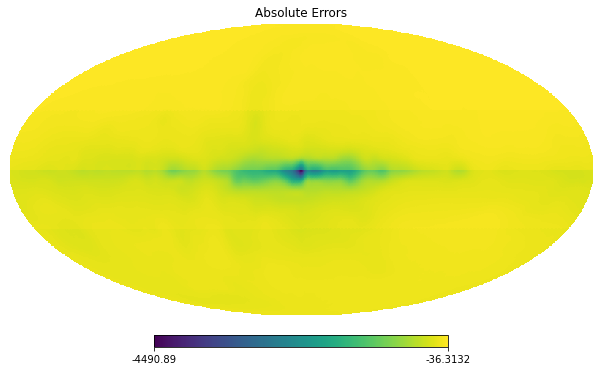

In [195]:
#How many regions do we want?
n_regions = 4
delta_percentiles = 100./n_regions


DataMap_wErrors = allsky_150MHz.copy()
Mask = np.zeros_like(Basemap_150MHz)

#make perturbed error map

percentiles = (95,30,15)
percentiles = (75,50, 25)
scafacs = (1.5, 1.25, 0.75, 0.5)

delta_pix = len(DataMap_wErrors)/n_regions

for i in range(n_regions):
    DataMap_wErrors[int(delta_pix*i):int(delta_pix*(i + 1))] = DataMap_wErrors[int(delta_pix)*i:int(delta_pix*(i + 1))]*scafacs[i]
    
#remainder
DataMap_wErrors[-len(DataMap_wErrors)%n_regions:] = DataMap_wErrors[-len(DataMap_wErrors)%n_regions:]*scafacs[-1]



hp.visufunc.mollview(DataMap_wErrors, title = "Data map")


frac_errors = np.true_divide(DataMap_wErrors, Basemap_150MHz)
hp.visufunc.mollview(frac_errors, title = "Fractional Errors")


abs_errors = np.subtract(DataMap_wErrors , Basemap_150MHz)
hp.visufunc.mollview(abs_errors, title = "Absolute Errors")


Jump in percentile increments of 25.0
First region consists of points less than   -217.3316650390625
Region 1 consists of points between -217.3316650390625 and -160.6501693725586
Region 2 consists of points between -160.6501693725586 and -86.855712890625
Last region consists of points greate than  -86.855712890625
Jump in percentile increments of 25.0
First region consists of points less than   0.3437499776482582
Region 1 consists of points between 0.3437499776482582 and 0.4999999850988388
Region 2 consists of points between 0.4999999850988388 and 0.6562500298023224
Last region consists of points greate than  0.6562500298023224


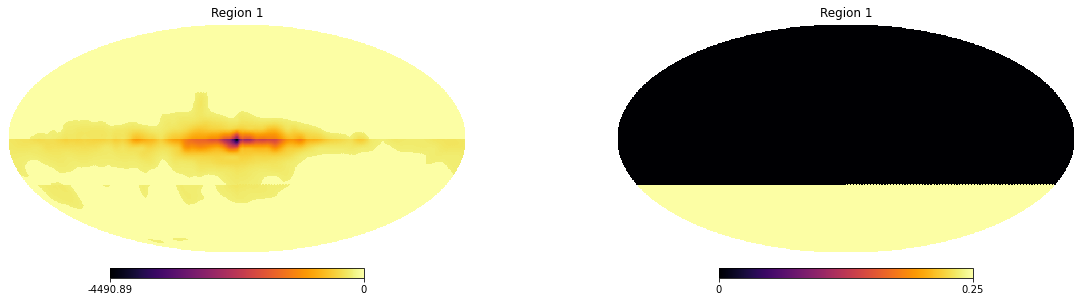

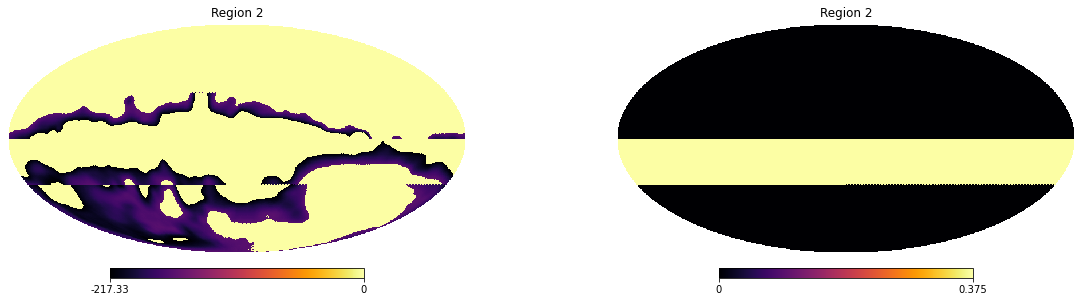

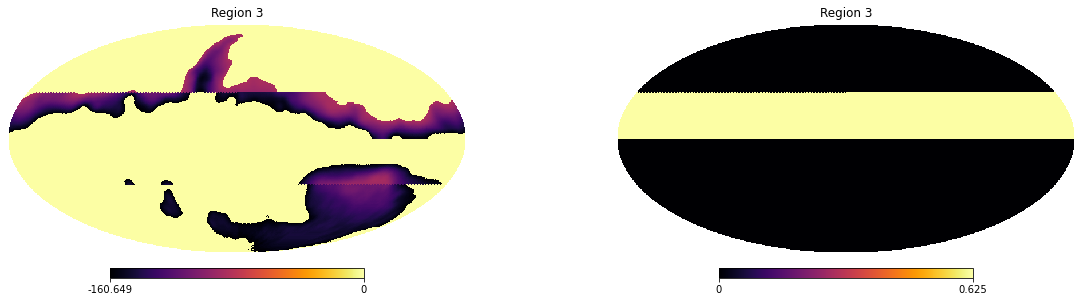

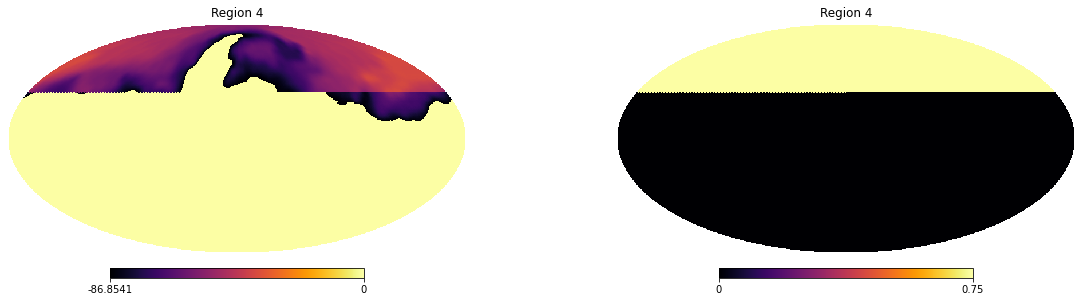

In [202]:
from generate_masks import GenerateMasks

AbsMasks = GenerateMasks(4, abs_errors)
masks_abs_errors = AbsMasks.masks
for i in range(N_reg_scafac):
    break
    hp.visufunc.mollview(np.multiply(input_map, masks_abs_errors[:,i]) , title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()
    
    
FracMasks = GenerateMasks(4, frac_errors)
masks_frac_errors = FracMasks.masks
for i in range(N_reg_scafac):
    break
    hp.visufunc.mollview(np.multiply(input_map, masks_frac_errors[:,i]) , title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()
    


#take a look to see if everything went well
for i in range(N_reg_scafac):
    #break
 
    fig, (ax1, ax2) = pl.subplots(ncols=2, figsize = (20,5))
    pl.axes(ax1)
    hp.visufunc.mollview(np.multiply(abs_errors, masks_abs_errors[:,i]) , hold = True, title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.axes(ax2)
    hp.visufunc.mollview(np.multiply(frac_errors, masks_frac_errors[:,i]) , hold = True, title = 'Region ' + str(i+1), cmap = 'inferno')
    pl.show()
    pl.close()





